# FullSim Hxx comparison

I'll compare the Hxx from full sim with each other to see if everything looks fine. I'll do the same plots as in the previous notebook (full-vs-fast-sim(bb)).

The root files used are from `/afs/cern.ch/work/s/saaumill/public/Hxx-inputNN-smalldata/` which were producted with the `create_fullsim_tagger_data.py` in this FullSimTagger repo.

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
save_status = False

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np")
    return data

In [4]:
path = "/afs/cern.ch/work/s/saaumill/public/final-fullsim-inputNN"

dic = {
    "uu": np.array([]),
    "dd": np.array([]),
    "cc": np.array([]),
    "ss": np.array([]),
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}-inputNN-smalldata.root")
    dic[process] = data
    

In [5]:
for pro in dic.keys():
    print(pro, len(dic[pro]["jet_e"]))

uu 3800
dd 3600
cc 3800
ss 3600
bb 3800
gg 4000
tautau 3798


In [6]:
for param in dic.values():
    print(max(param["jet_e"]))

148.69629
122.33067
131.58882
321.43918
148.22154
130.57552
155.38681


In [7]:
def histograms(keys, n, k, figsize=(13, 2), bins=50, conc=False, save=False, path=None):
    fig, axs = plt.subplots(n, k, figsize=figsize)
    
    for i, ax in enumerate(axs.flat): # loop over keys of histograms we wanna create
        ax.set_title(keys[i])
        ax.grid()
        try:
            combined_min = min(min(param[keys[i]]) for param in dic.values())
            combined_max = max(max(param[keys[i]]) for param in dic.values())
        except ValueError:
            combined_min = min(min(np.concatenate(param[keys[i]])) for param in dic.values())
            combined_max = max(max(np.concatenate(param[keys[i]])) for param in dic.values())
        combined_range = (combined_min, combined_max)

        for pro in dic.keys(): # loop over all Hxx processes 
            if conc==False:
                ax.hist(dic[pro][keys[i]], bins=bins, range=combined_range, label=f'H{pro}', histtype='step', linewidth=2.0, density=True) # set density=True to normalize
            else: 
                ax.hist(np.concatenate(dic[pro][keys[i]]), bins=bins, range=combined_range, histtype='step', linewidth=2.0, label=f'H{pro}', density=True) # set density=True to normalize
    
    plt.legend()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist-Hxx/histogram.pdf'
        plt.savefig(path)

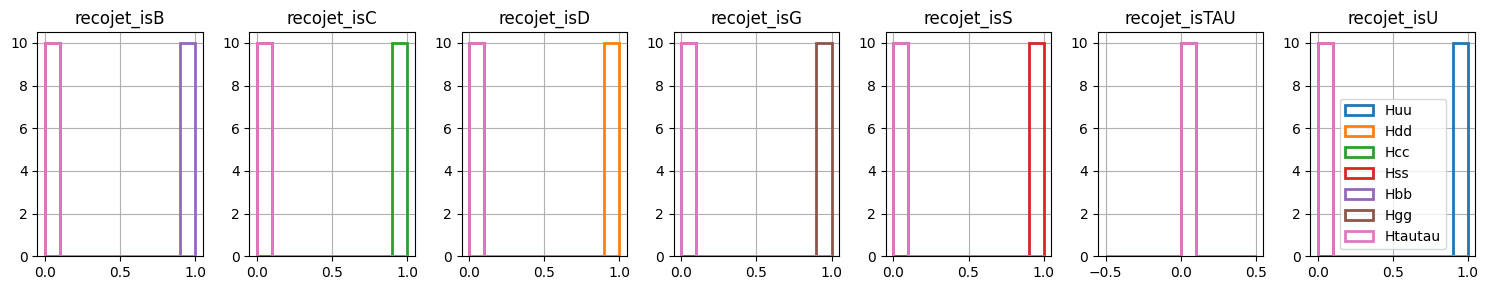

In [8]:
keys = ['recojet_isB',
 'recojet_isC',
 'recojet_isD',
 'recojet_isG',
 'recojet_isS',
 'recojet_isTAU',
 'recojet_isU']

histograms(keys, 1, 7, figsize=(15, 3), bins=10)

NOTE: in `tree_tools.py` line 42 - maybe it needs to be TAUTAU instead of tautau?! 

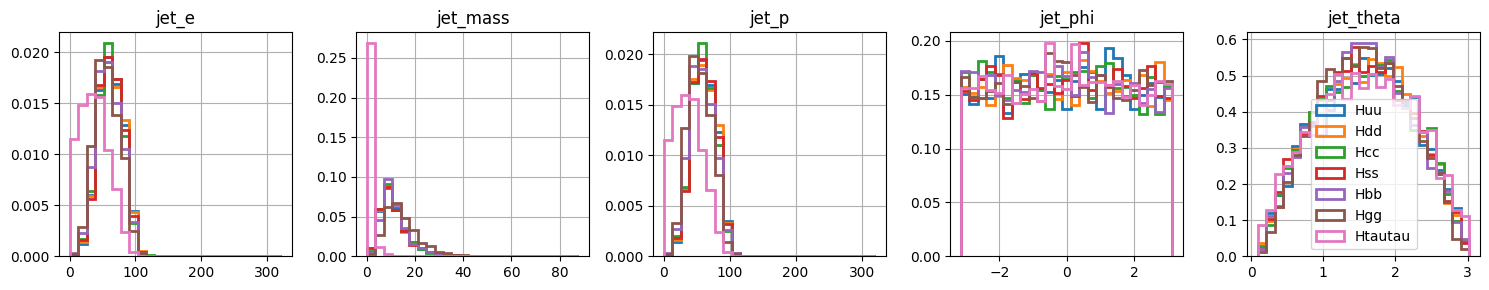

In [9]:
keys = ['jet_e',
 'jet_mass',
 'jet_p',
 'jet_phi',
 'jet_theta']


histograms(keys, 1, 5, figsize=(15, 3), bins=25, save=save_status, path='./hist-Hxx/jet_properties.pdf')

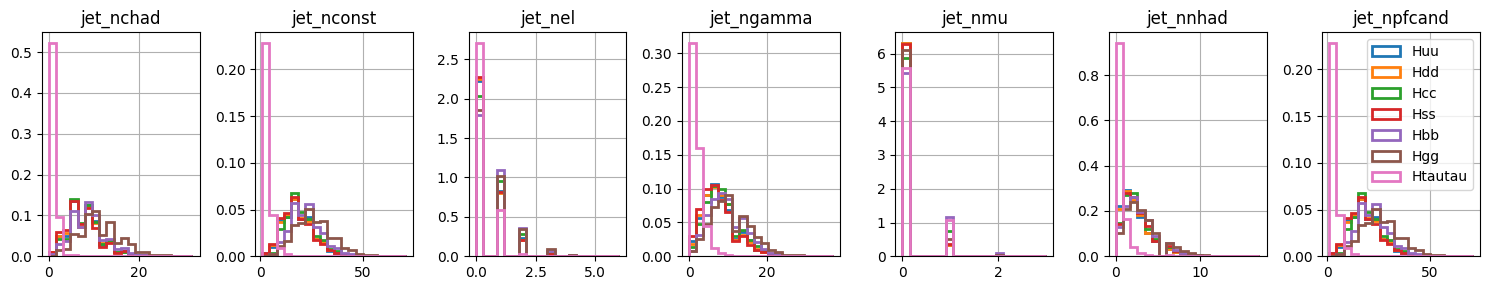

In [10]:
keys = ['jet_nchad',
 'jet_nconst',
 'jet_nel',
 'jet_ngamma',
 'jet_nmu',
 'jet_nnhad',
 'jet_npfcand']

histograms(keys, 1, 7, figsize=(15, 3), bins=20, save=save_status, path='./hist-Hxx/jet_multiplicities.pdf')

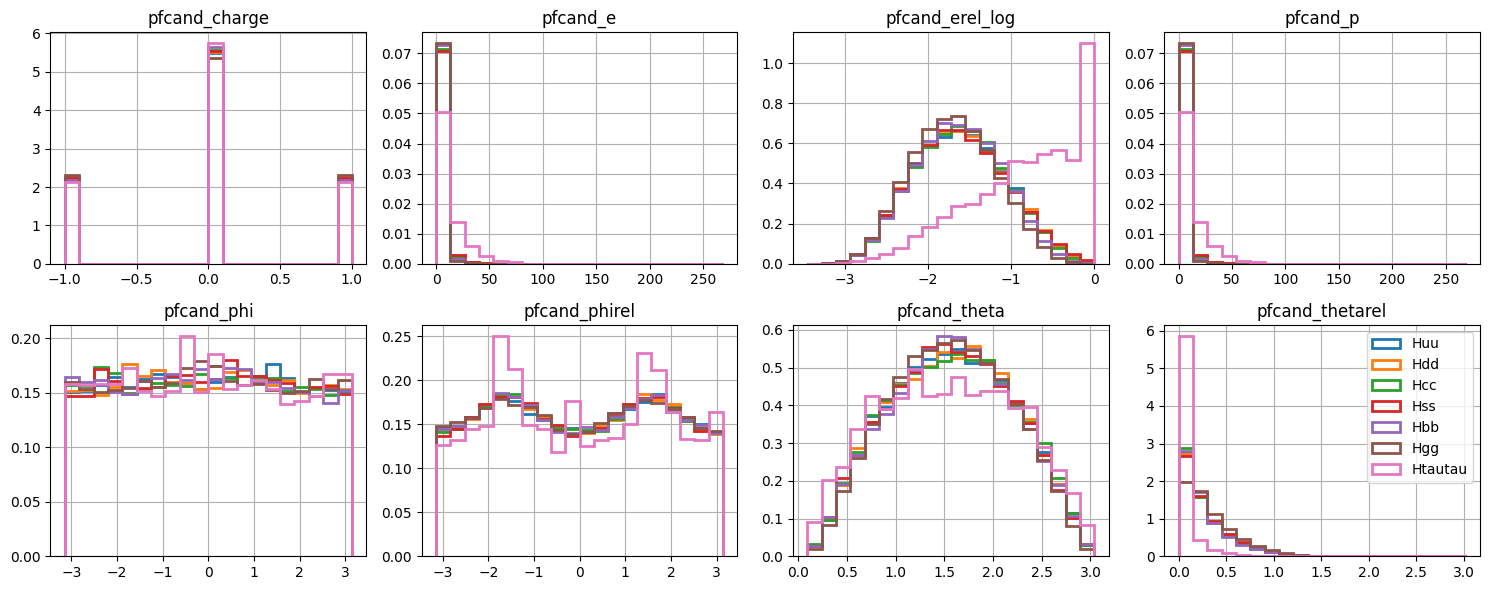

In [11]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

histograms(keys, 2, 4, figsize=(15, 6), bins=20, conc=True)

# Charged vs. neutral particles

In [12]:
def get_index_charged_particles(process, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    types = process['pfcand_type']
    if ptype=='cpart':
        num = [-211, -13, -11, 11, 13, 211] 
    elif ptype=='npart':
        num = [2112]
    elif ptype=='photon':
        num = [22]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [13]:
def get_value_highest_energy_particle(process, k=3, ptype='cpart'):
    """return the index of the k highest energy charged particle in each event"""
    particles_e = process['pfcand_e']
    mask_chad = get_index_charged_particles(process, ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
    return index_charged

In [14]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [15]:
def plot_key_highest_e_cpart(keys, ptype="cpart", k=3, r=None, bins=20, log=False, save=False, path=None, smalllabel=False):
    fig, axs = plt.subplots(len(keys), k, figsize=(15, 3 * len(keys))) 

    # loop over keys: 
    for idx, key in enumerate(keys):
        ri = r[key] if r != None else None
        if ri == None:
            try:
                combined_min = min(min(param[keys[idx]]) for param in dic.values())
                combined_max = max(max(param[keys[idx]]) for param in dic.values())
            except ValueError:
                combined_min = min(min(np.concatenate(param[keys[idx]])) for param in dic.values())
                combined_max = max(max(np.concatenate(param[keys[idx]])) for param in dic.values())
            combined_range = (combined_min, combined_max)
            combined_range = (combined_min, combined_max)
        else:
            combined_range = ri


        for pro in dic.keys(): # loop over all Hxx processes
            index = get_value_highest_energy_particle(process=dic[pro], ptype=ptype, k=k)
            a_list = get_chad_elements(dic[pro][key], index)

            for i in range(k):
                ax = axs[idx, i] 
                a = a_list[i]

                if ri != None:
                    # make overflow bins
                    a = np.clip(a, *combined_range)
                
                ax.set_title(key)
                if smalllabel:
                    label = f'H{pro}'
                else:
                    label = f'H{pro} {i+1}'+r'. highest $E$'
                ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=label, density=True)
                if log:
                    ax.set_yscale('log')
                if idx == 0:
                    ax.legend()
                ax.grid()
    plt.tight_layout()
    if save:
        if path==None:
            path = './hist-Hxx/histogram.pdf'
        plt.savefig(path)
    plt.show()

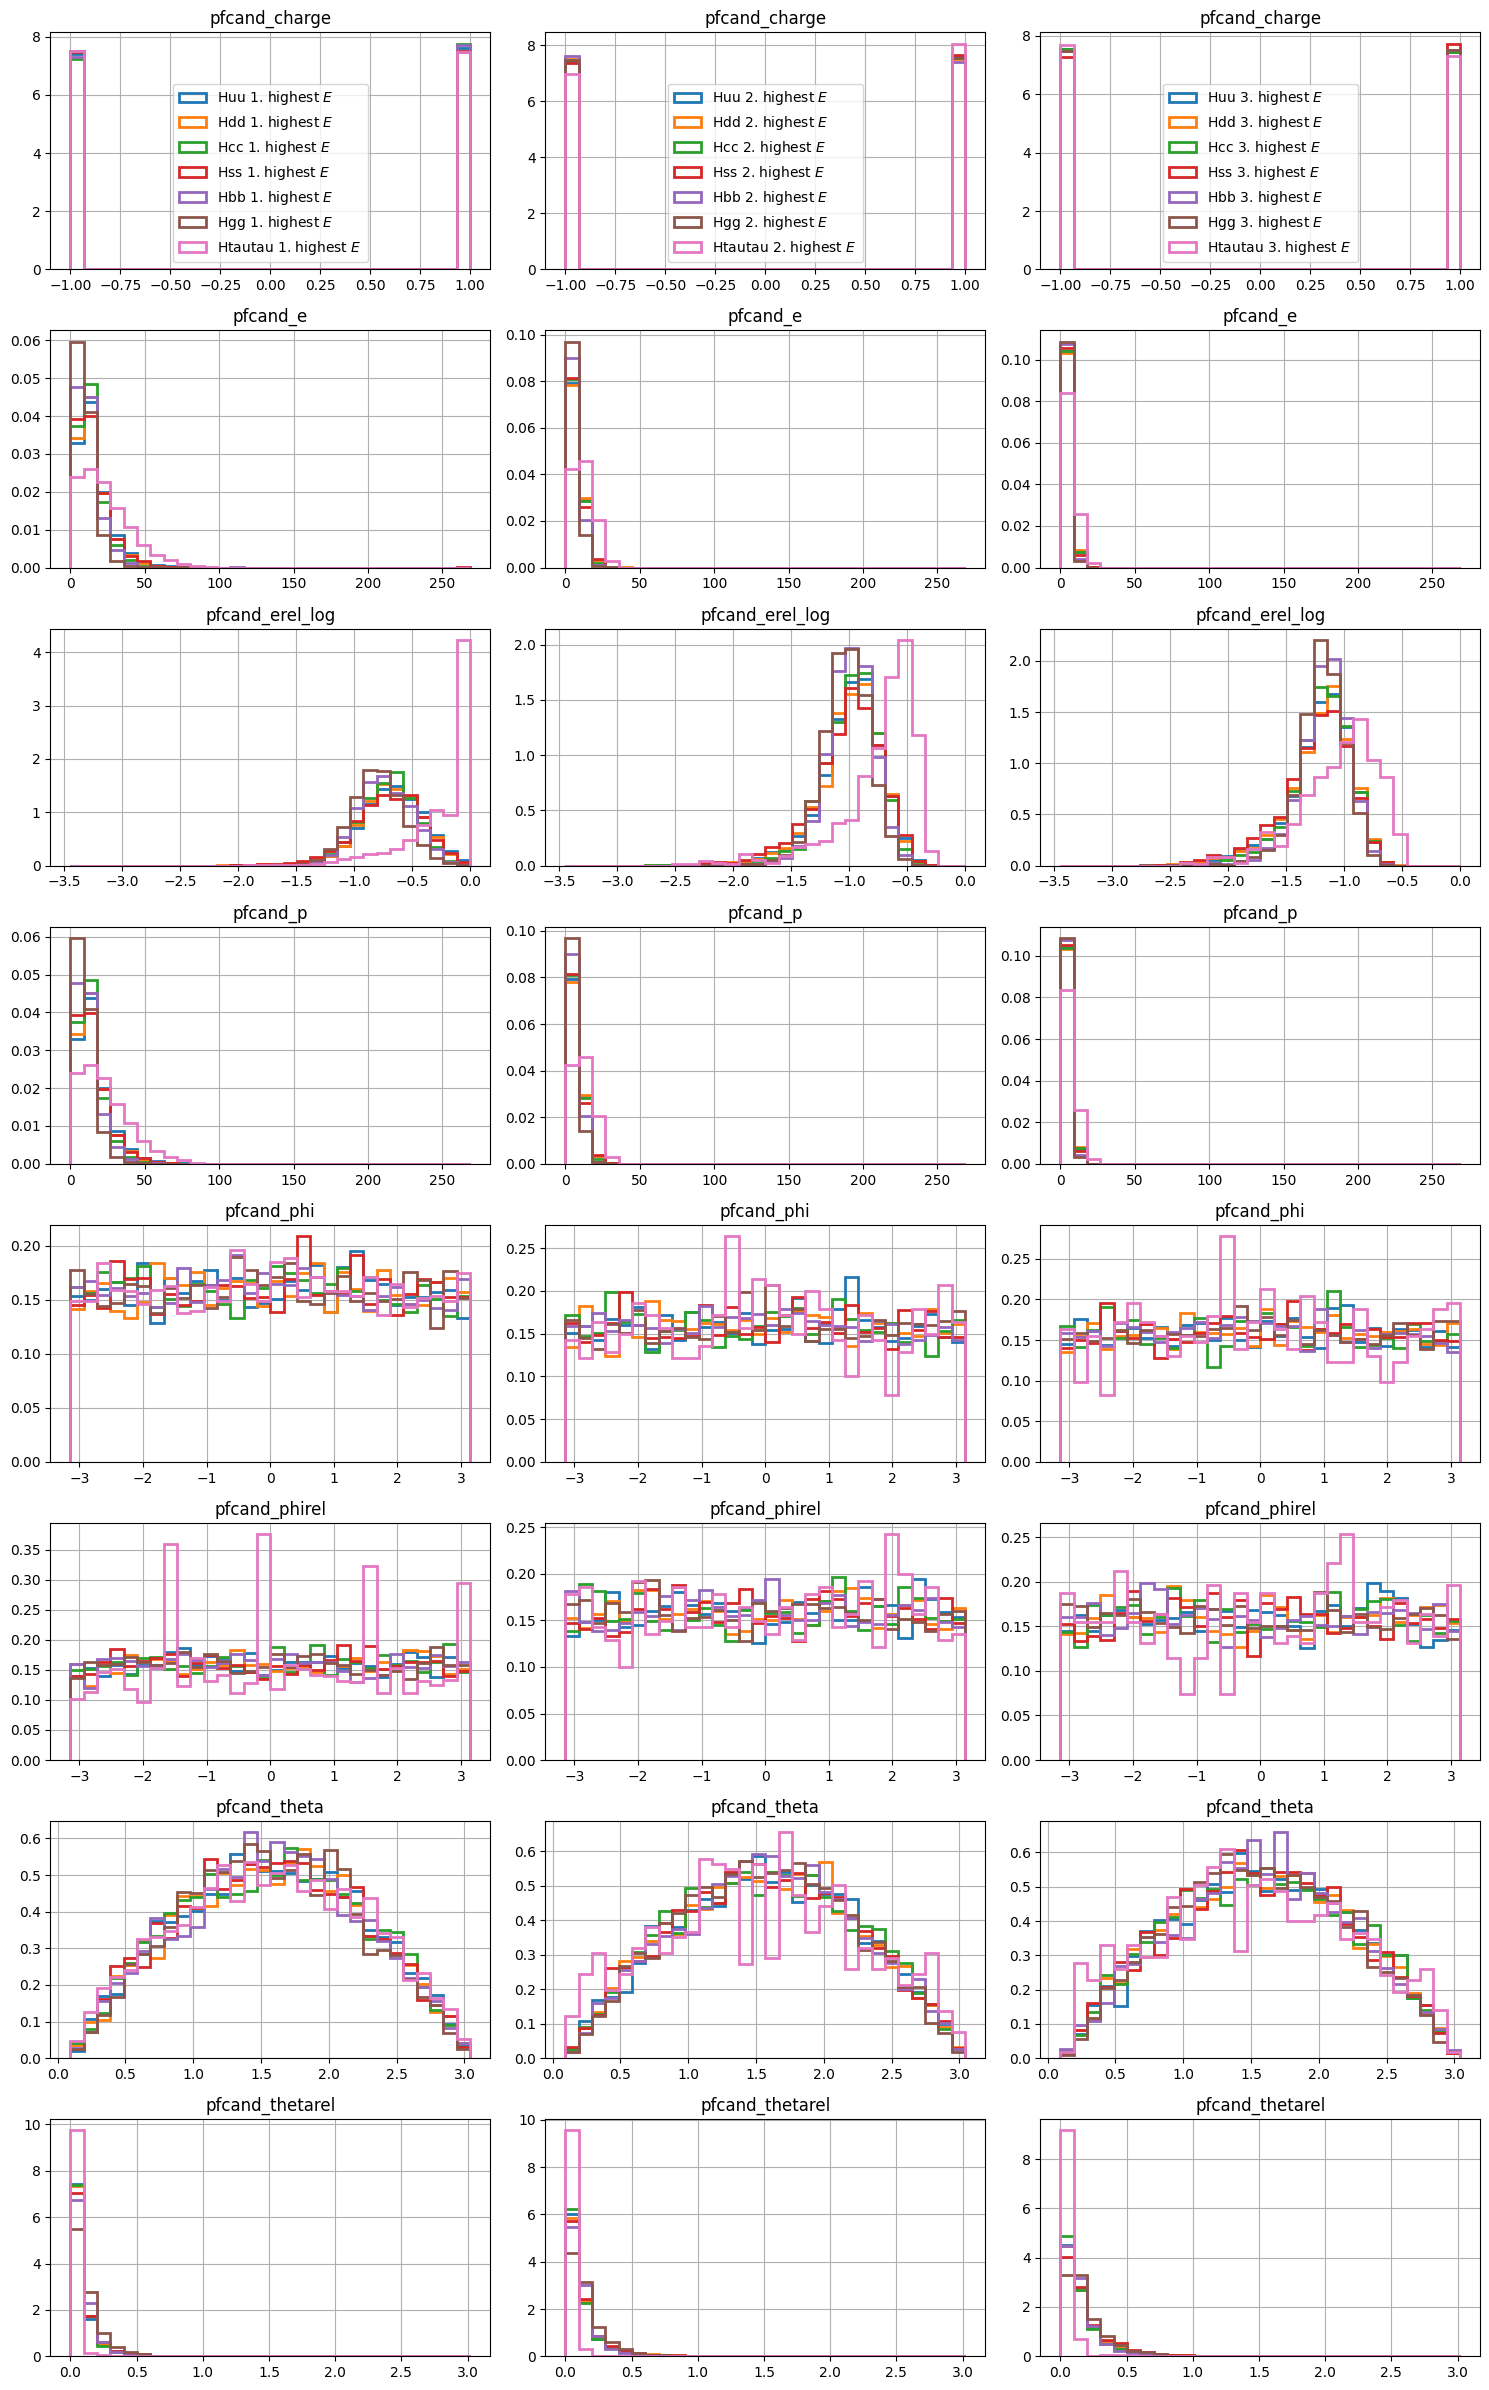

In [16]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, bins=30, save=save_status, path='./hist-Hxx/jetct_cp_properties.pdf')

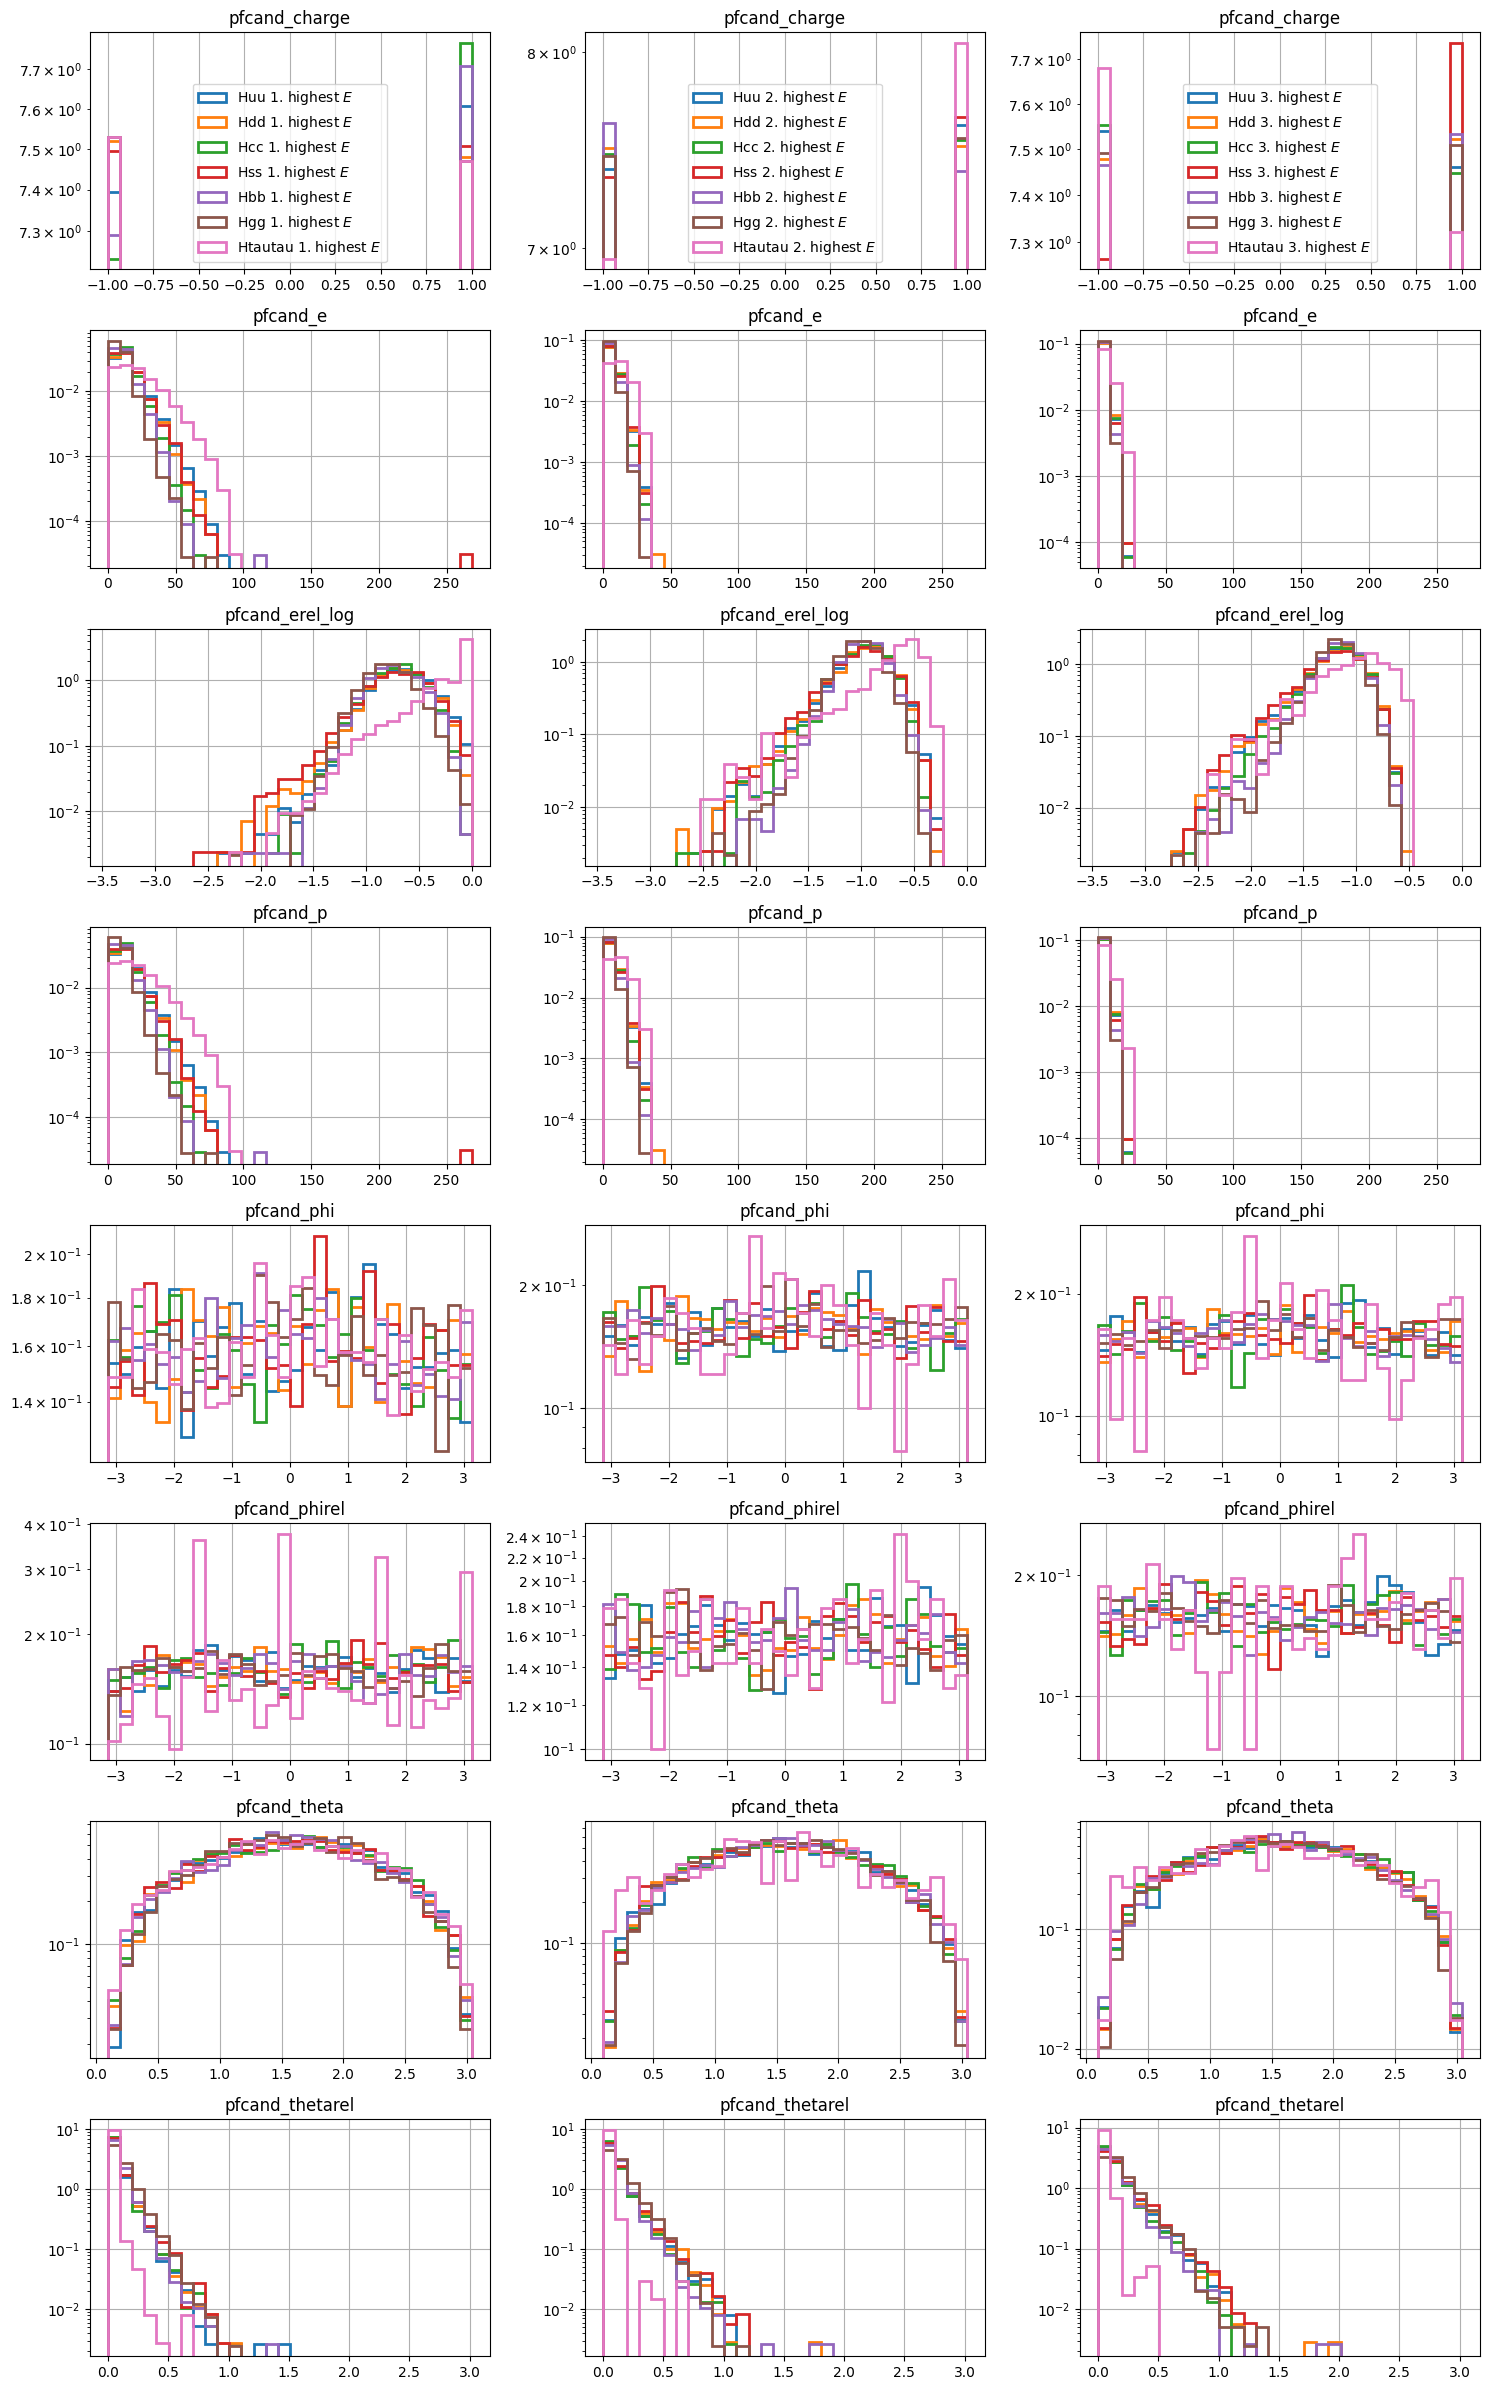

In [17]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, bins=30, save=save_status, log=True, path='./hist-Hxx/jetct_cp_properties_log.pdf')

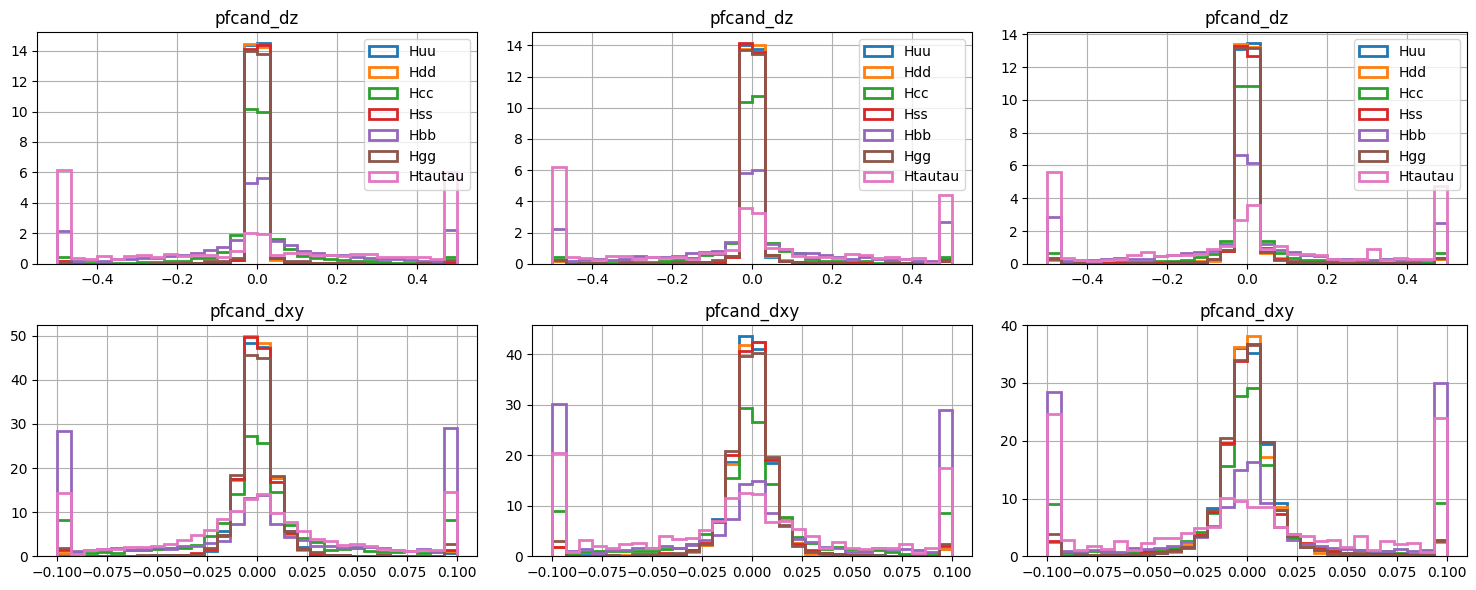

In [18]:
keys = ['pfcand_dz',
        'pfcand_dxy']

ranges = {
    'pfcand_dz': [-0.5, 0.5],
    'pfcand_dxy': [-0.1, 0.1]}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist-Hxx/jetct_cp_ip.pdf', smalllabel=True)

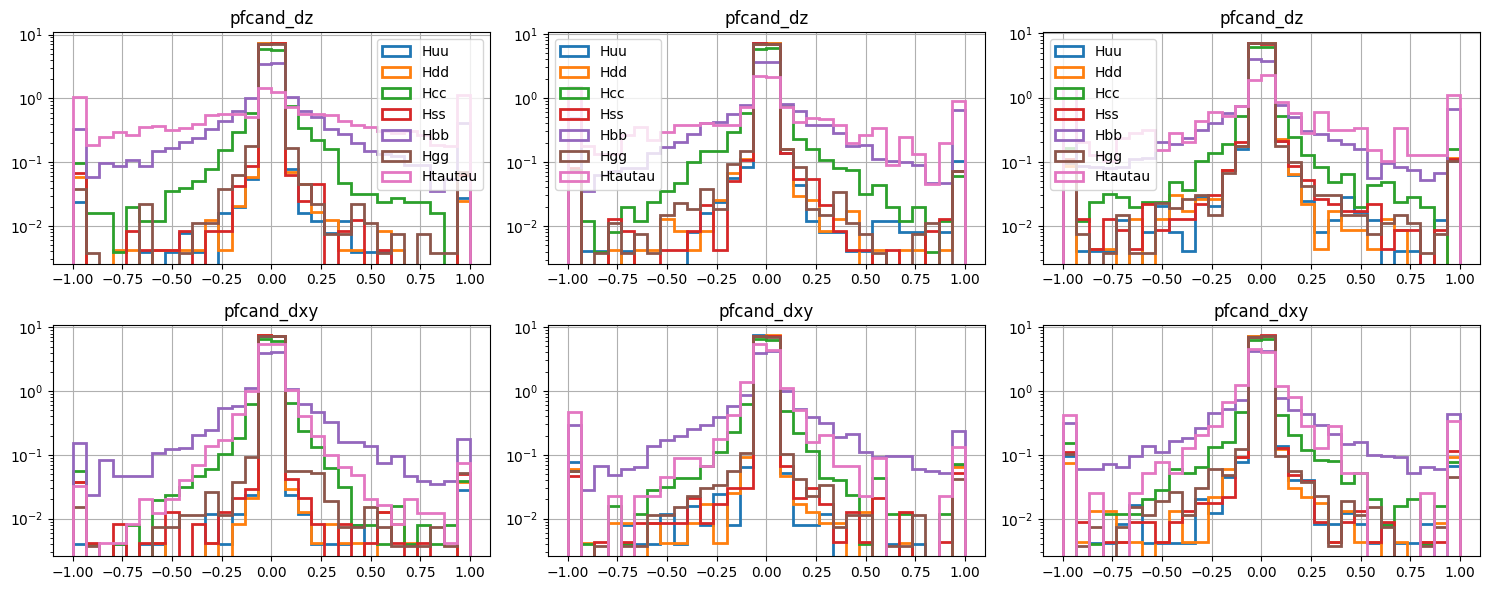

In [19]:
keys = ['pfcand_dz',
        'pfcand_dxy']

ranges = {
    'pfcand_dz': [-1, 1],
    'pfcand_dxy': [-1, 1]}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, log=True, save=save_status, path='./hist-Hxx/jetct_cp_ip_log.pdf', smalllabel=True)

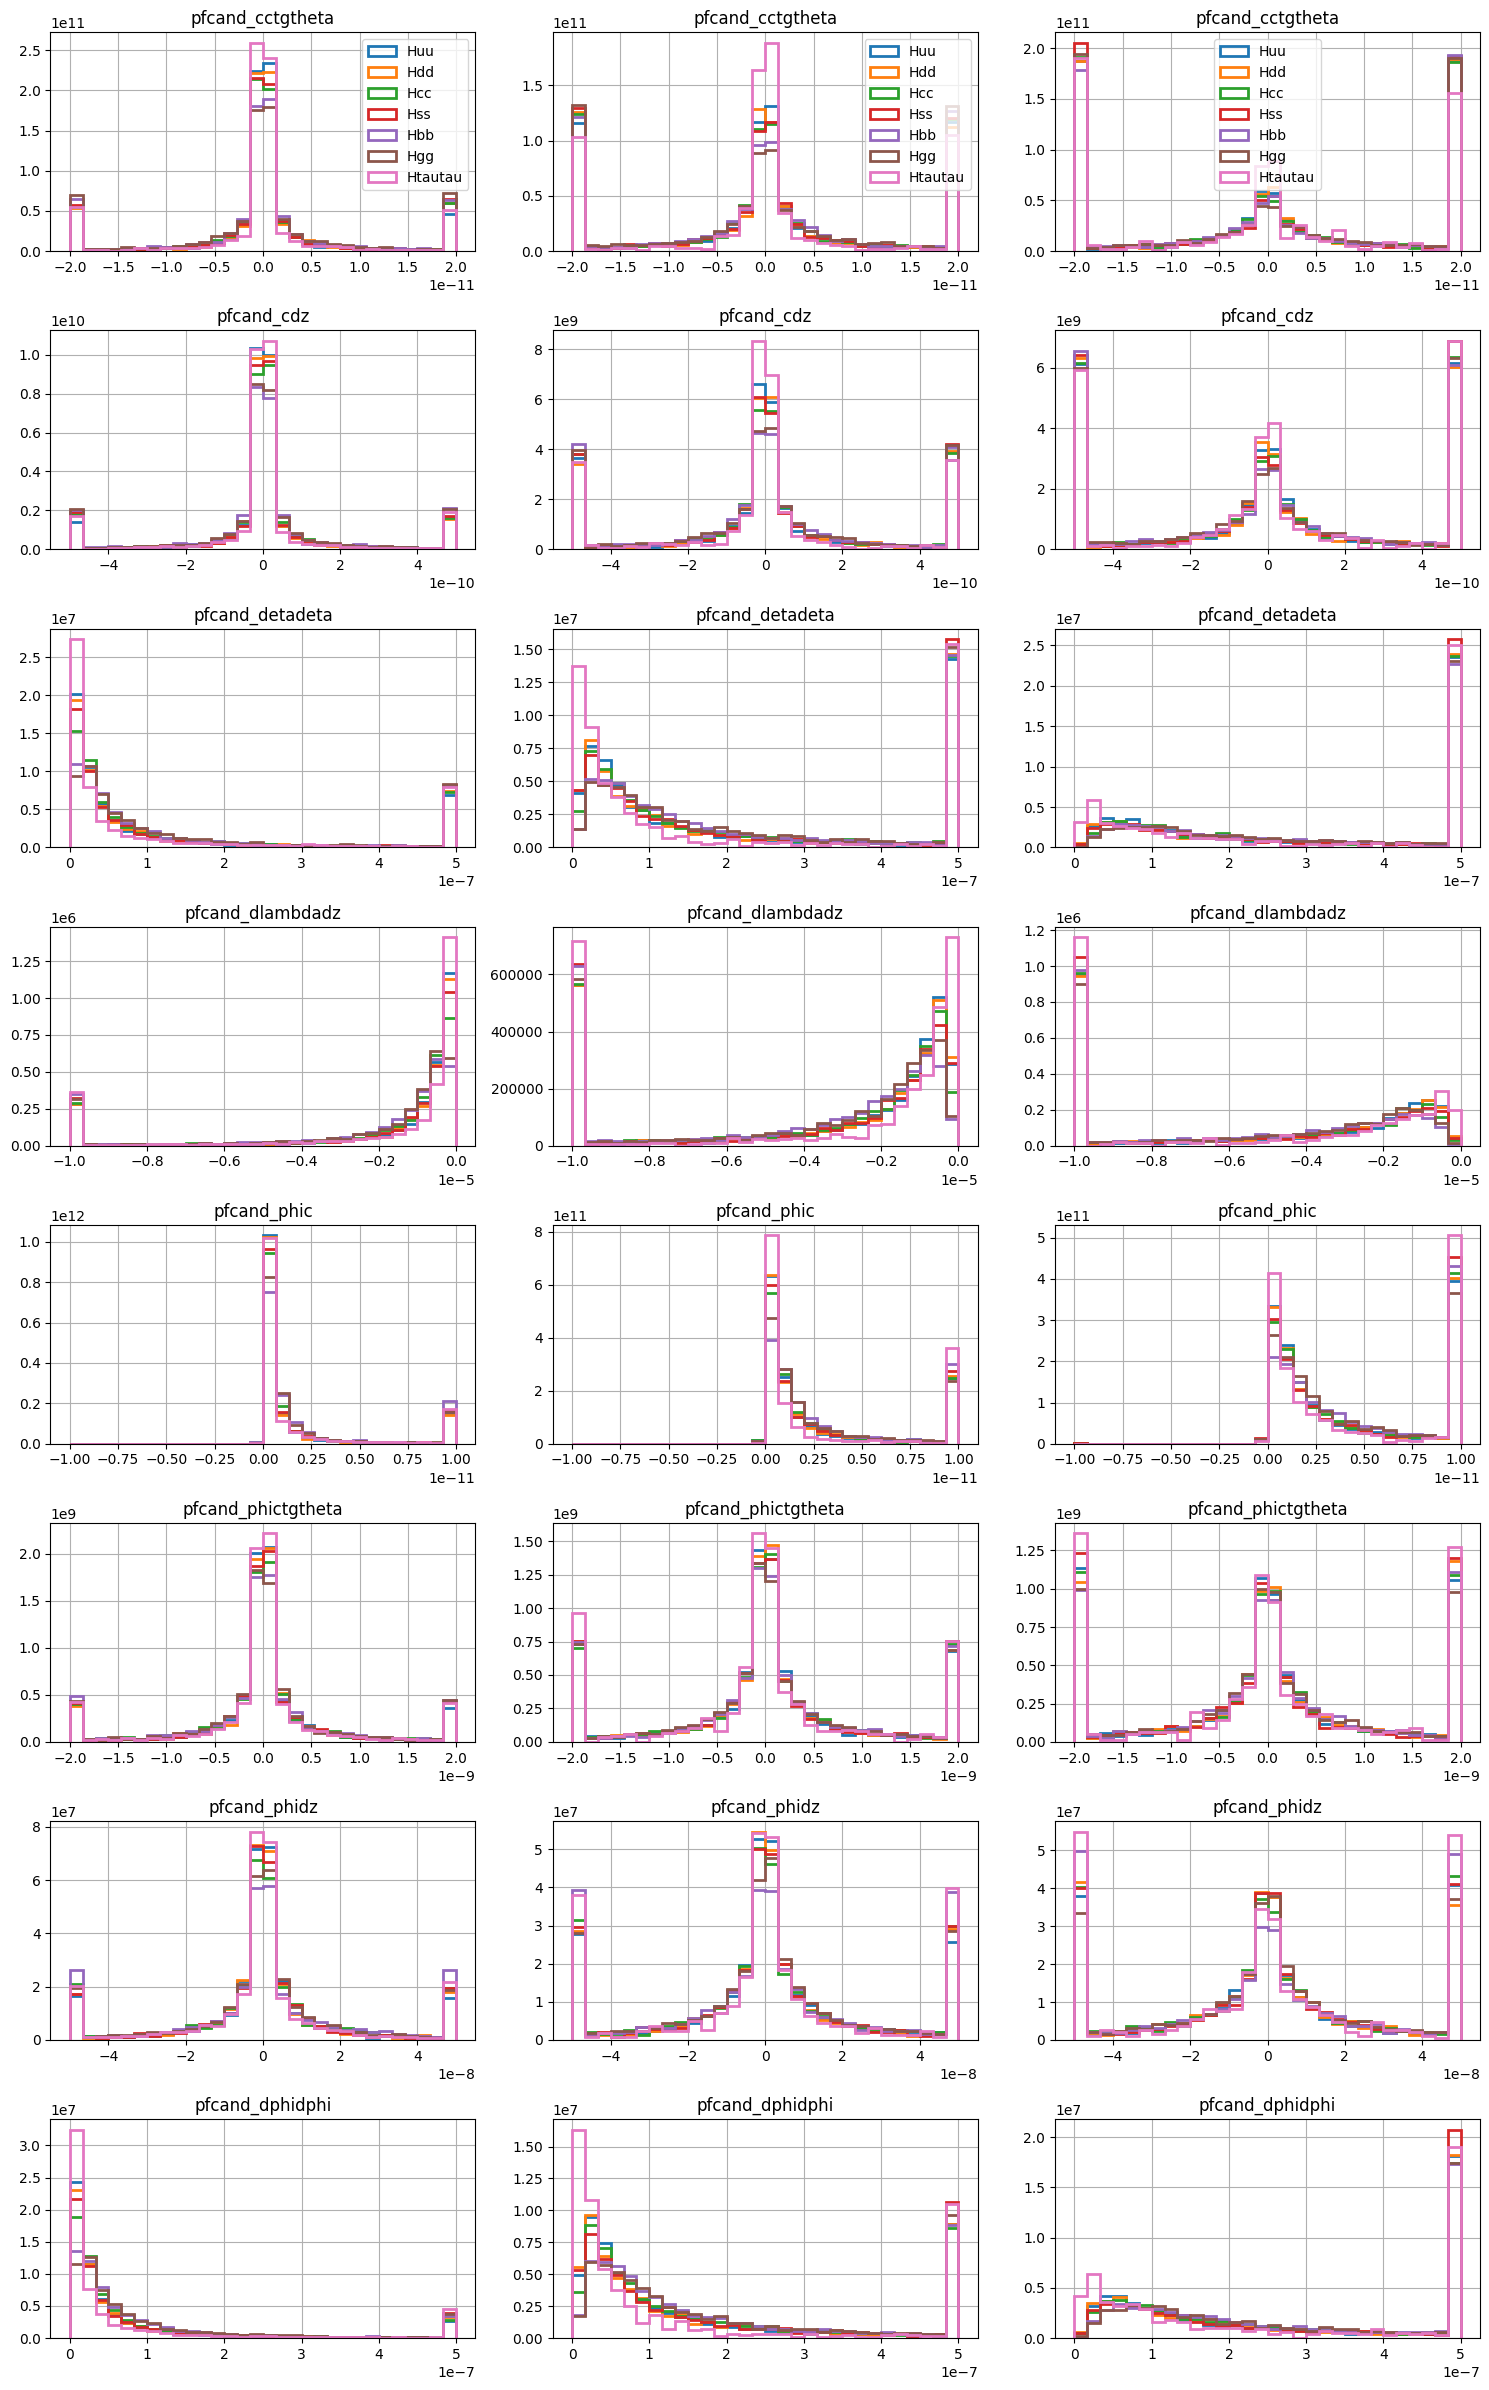

In [20]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_cctgtheta',
 'pfcand_cdz',
 'pfcand_detadeta',
 'pfcand_dlambdadz',
 'pfcand_phic',
 'pfcand_phictgtheta',
 'pfcand_phidz',
 'pfcand_dphidphi']

ranges = {
    'pfcand_cctgtheta': [-0.2e-10, 0.2e-10],
    'pfcand_cdz': [-0.5e-09, 0.5e-09],
    'pfcand_detadeta': [0, 0.5e-6],
    'pfcand_dlambdadz': [-1e-5, 0],
    'pfcand_phic': [-0.1e-10, 0.1e-10],
    'pfcand_phictgtheta': [-0.2e-08, 0.2e-08], 
    'pfcand_phidz': [-0.05e-6, 0.05e-6],
    'pfcand_dphidphi': [0.0, 0.5e-6]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist-Hxx/jetct_cp_cov1.pdf', smalllabel=True)

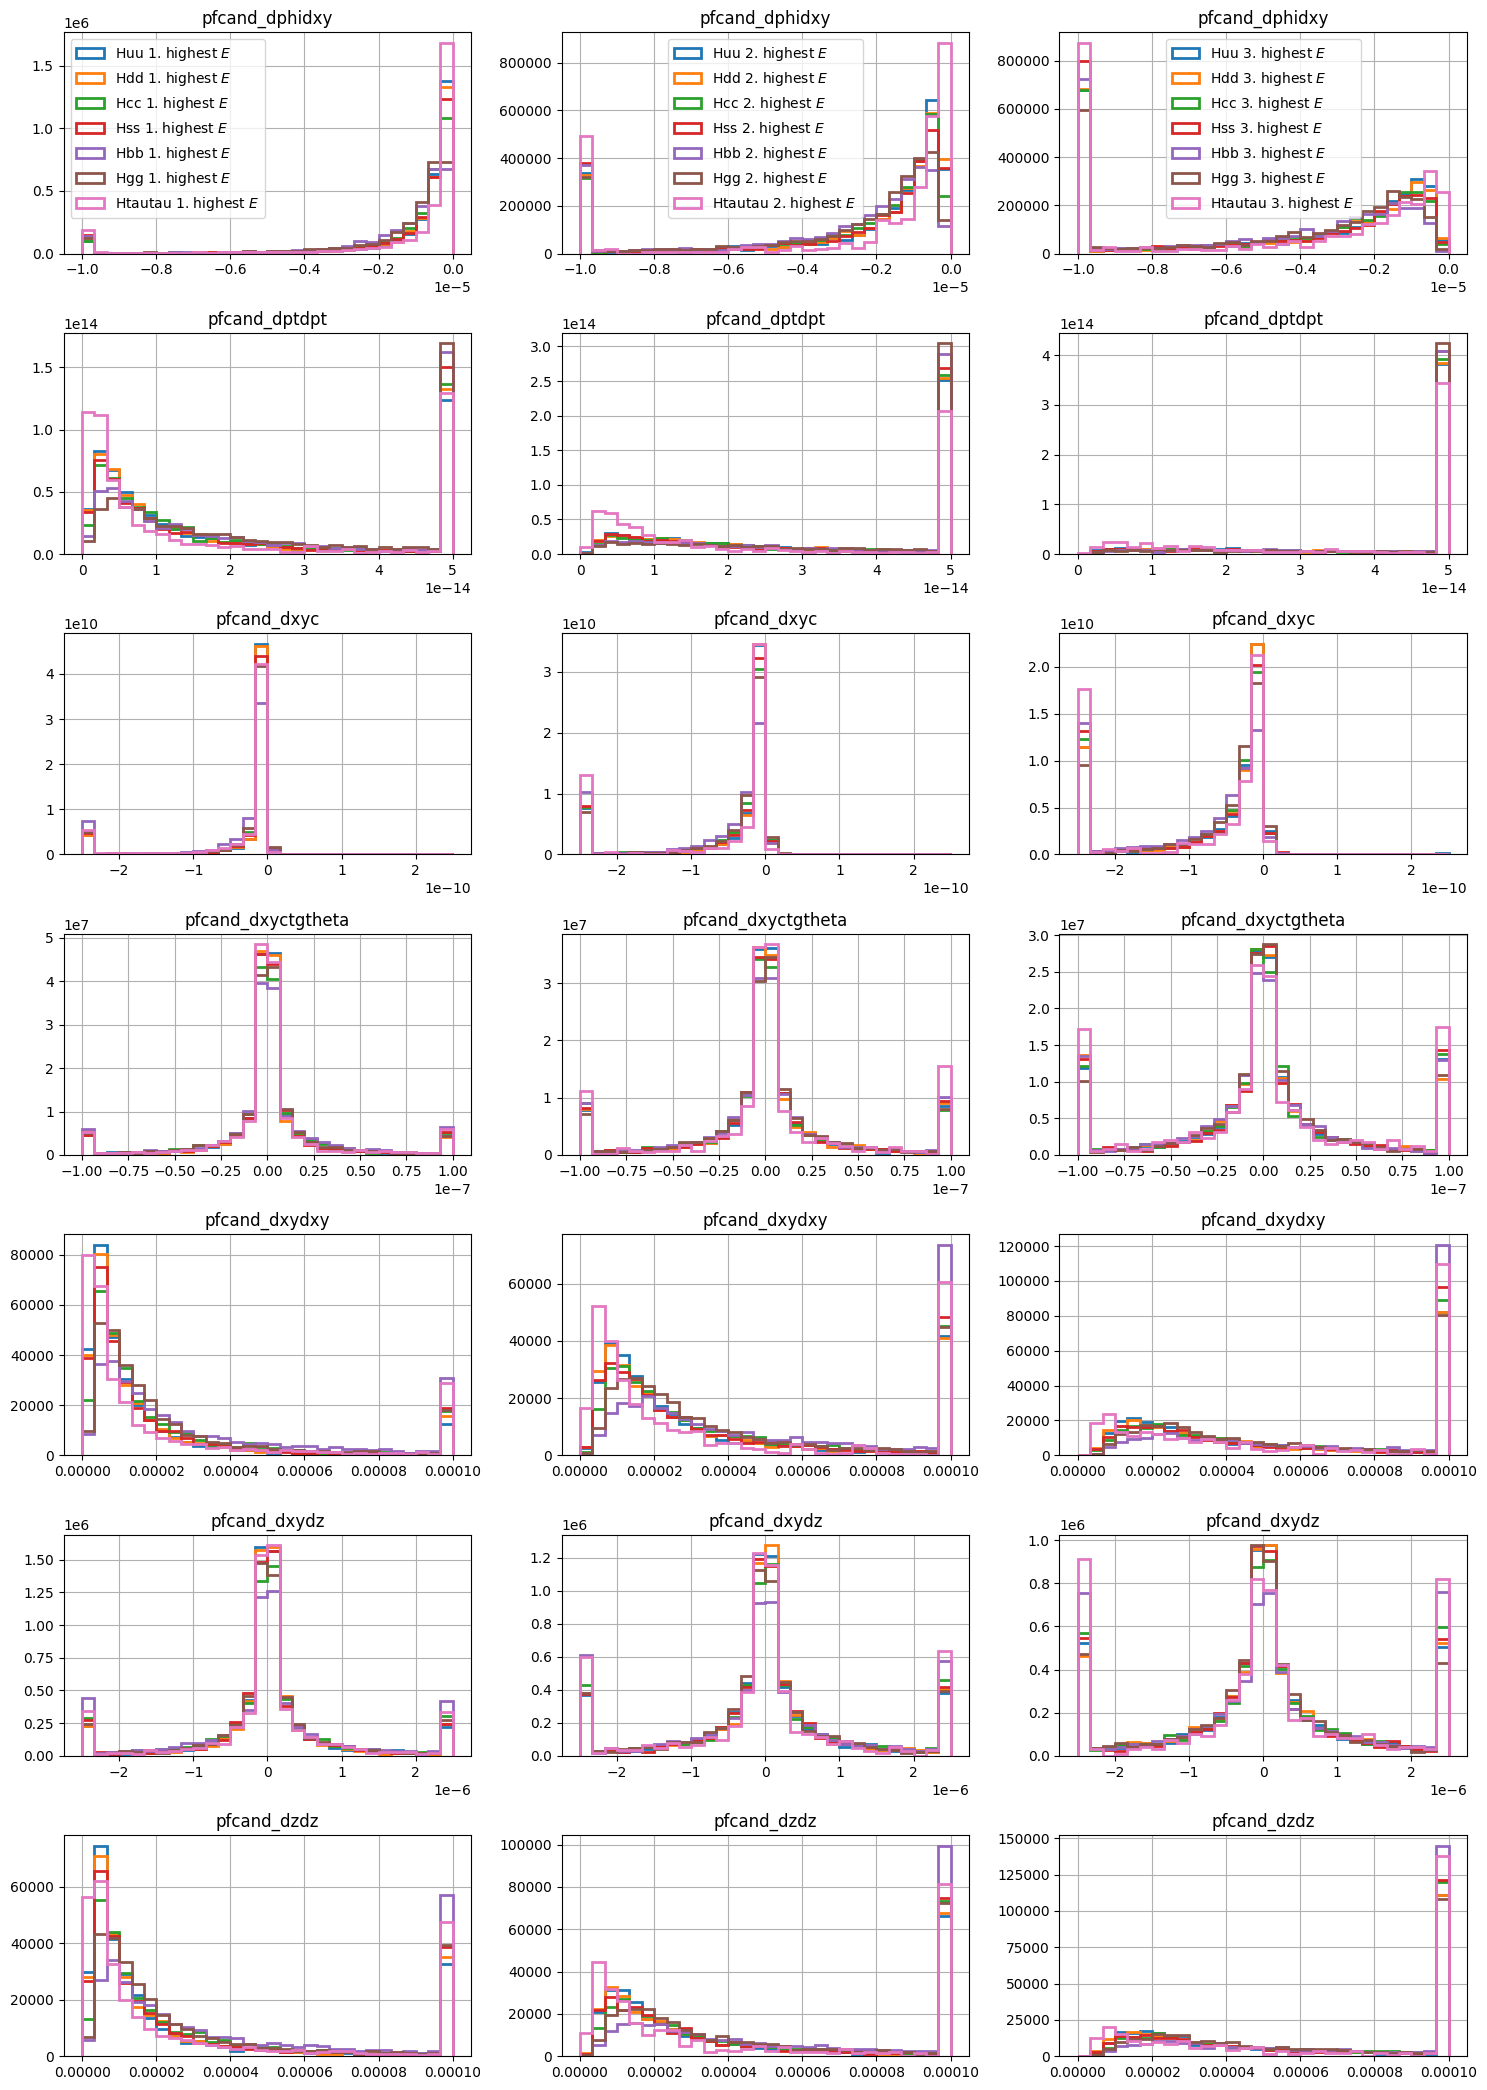

In [21]:
# this plot should be better because we look at charged hadrons only which leave a track!

keys = [
 'pfcand_dphidxy',
 'pfcand_dptdpt',
 'pfcand_dxyc',
 'pfcand_dxyctgtheta',
 'pfcand_dxydxy',
 'pfcand_dxydz',
 'pfcand_dzdz']

ranges = {
    'pfcand_dphidxy': [-1e-5, 0],
    'pfcand_dptdpt': [0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 1e-4],
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist-Hxx/jetct_cp_cov2.pdf')

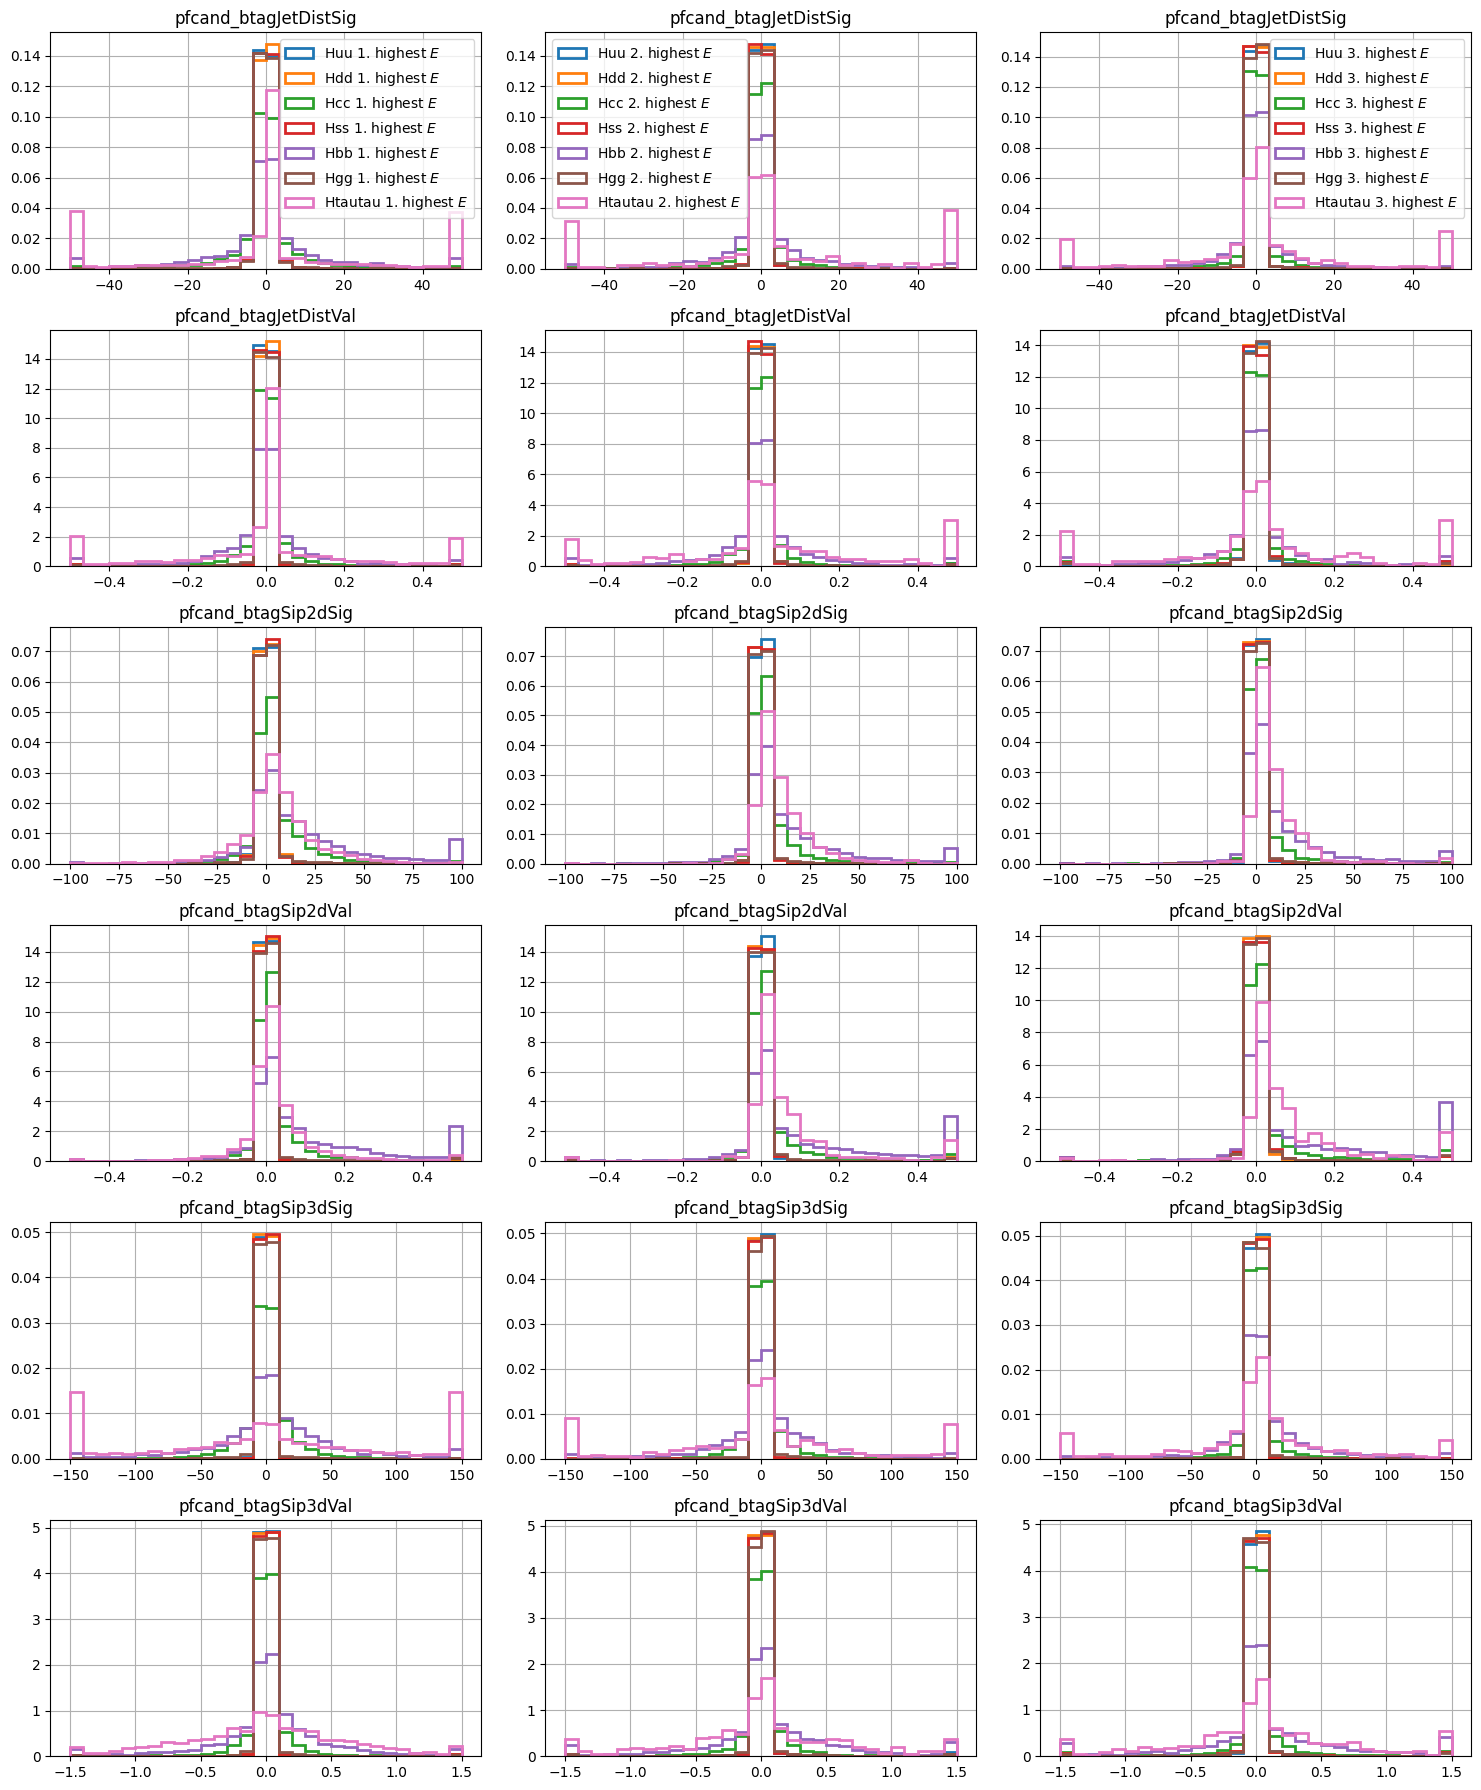

In [22]:
# these plots make even more sense than the one above because we look at charged hadrons only which leave a track!

keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

ranges = {
    'pfcand_btagJetDistSig': [-50, 50],
    'pfcand_btagJetDistVal': [-0.5, 0.5],
    'pfcand_btagSip2dSig': [-100, 100],
    'pfcand_btagSip2dVal': [-0.5, 0.5],
    'pfcand_btagSip3dSig': [-150, 150],
    'pfcand_btagSip3dVal': [-1.5, 1.5]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist-Hxx/jetct_cp_dist.pdf')

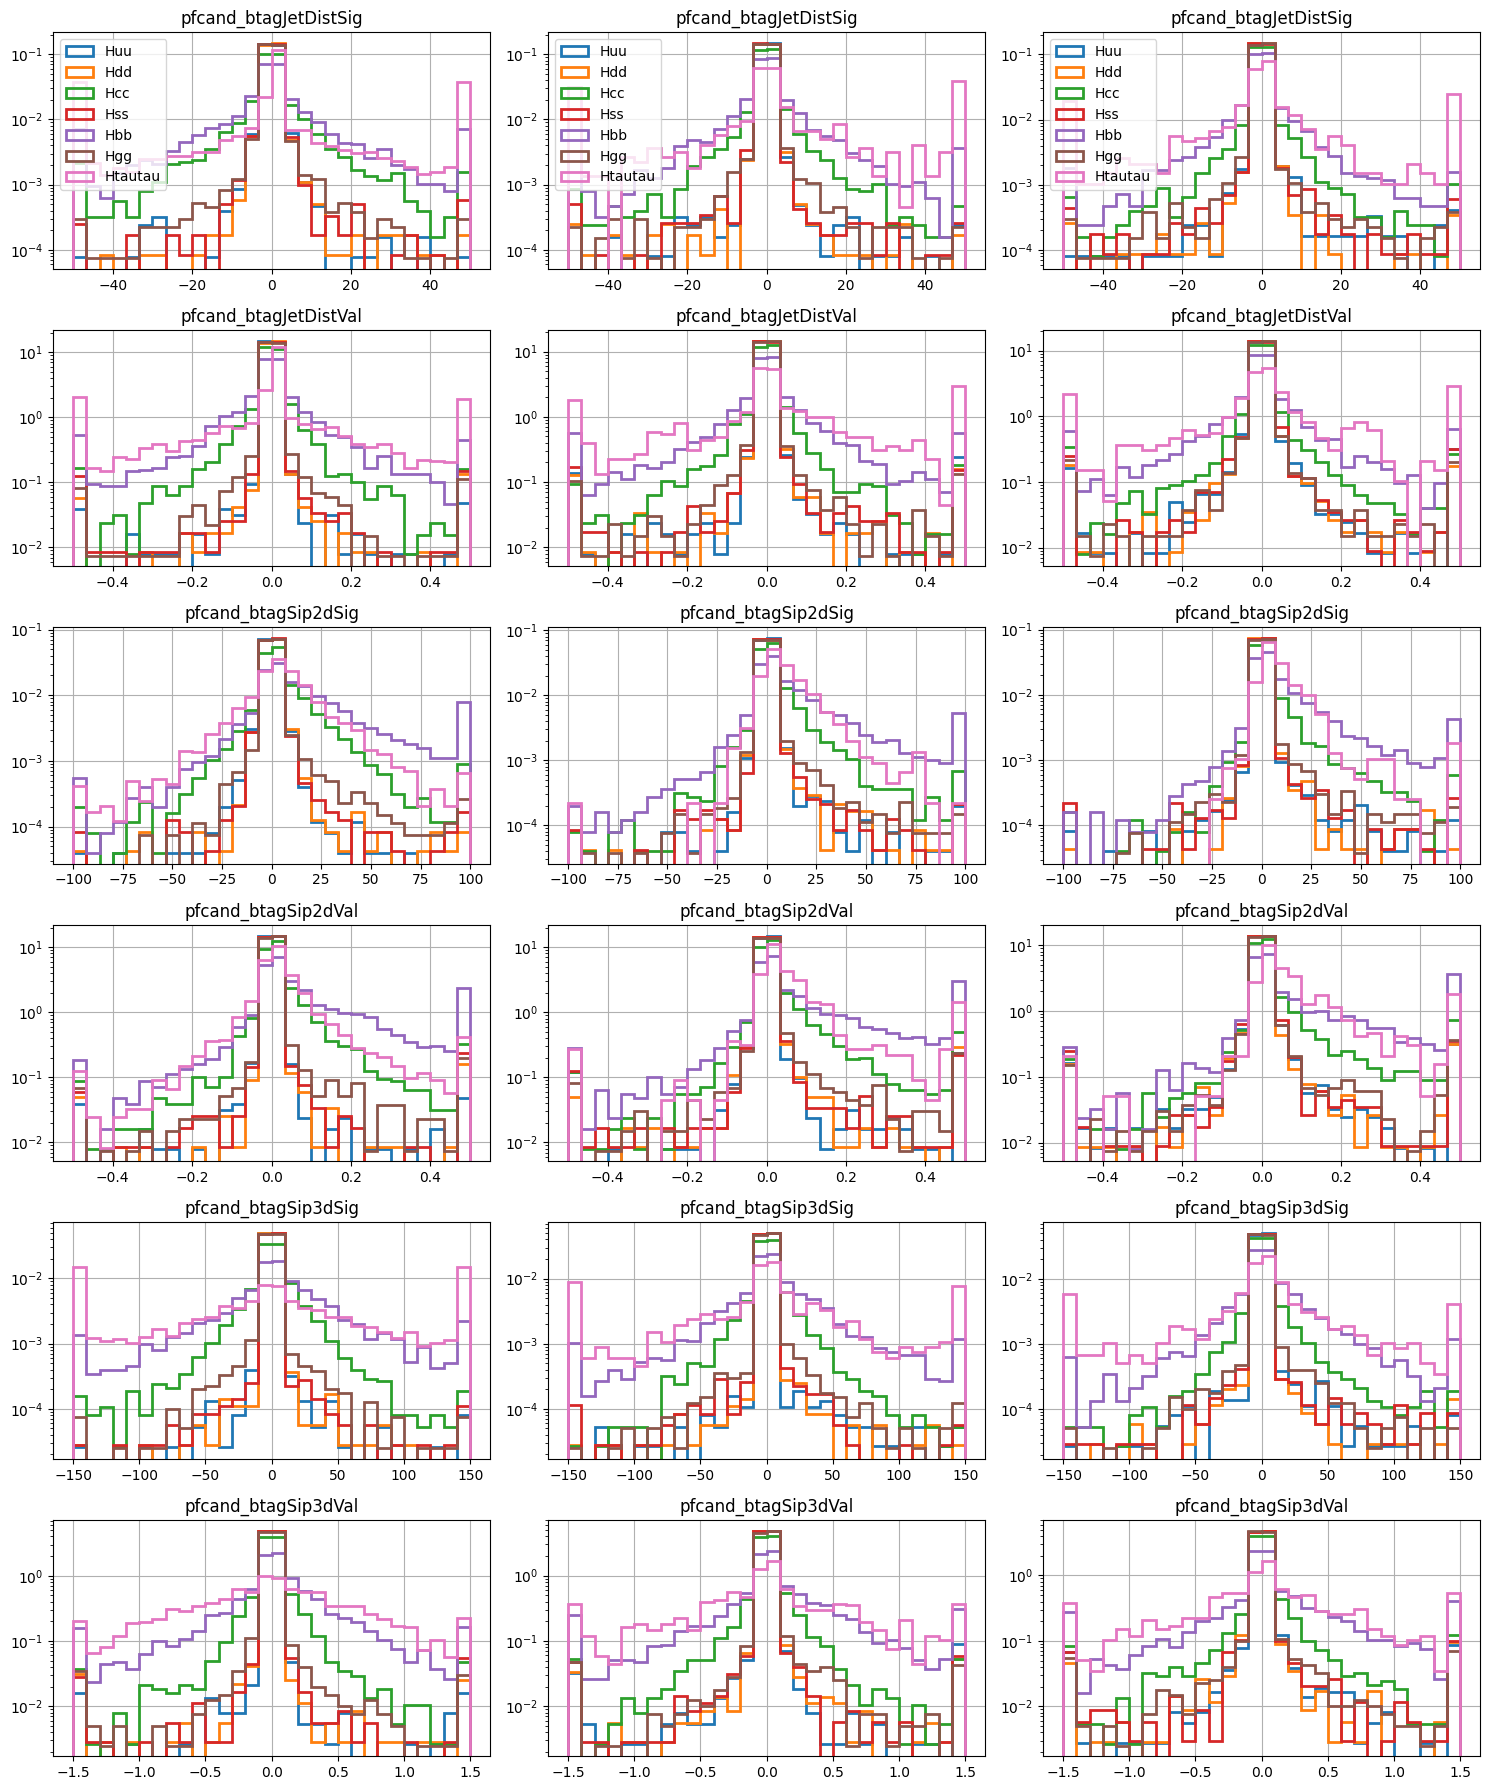

In [23]:
# these plots make even more sense than the one above because we look at charged hadrons only which leave a track!

keys = ['pfcand_btagJetDistSig',
 'pfcand_btagJetDistVal',
 'pfcand_btagSip2dSig',
 'pfcand_btagSip2dVal',
 'pfcand_btagSip3dSig',
 'pfcand_btagSip3dVal']

ranges = {
    'pfcand_btagJetDistSig': [-50, 50],
    'pfcand_btagJetDistVal': [-0.5, 0.5],
    'pfcand_btagSip2dSig': [-100, 100],
    'pfcand_btagSip2dVal': [-0.5, 0.5],
    'pfcand_btagSip3dSig': [-150, 150],
    'pfcand_btagSip3dVal': [-1.5, 1.5]
}

plot_key_highest_e_cpart(keys, r=ranges, bins=30, save=save_status, path='./hist-Hxx/jetct_cp_dist.pdf', log=True, smalllabel=True)

# Neutral particles

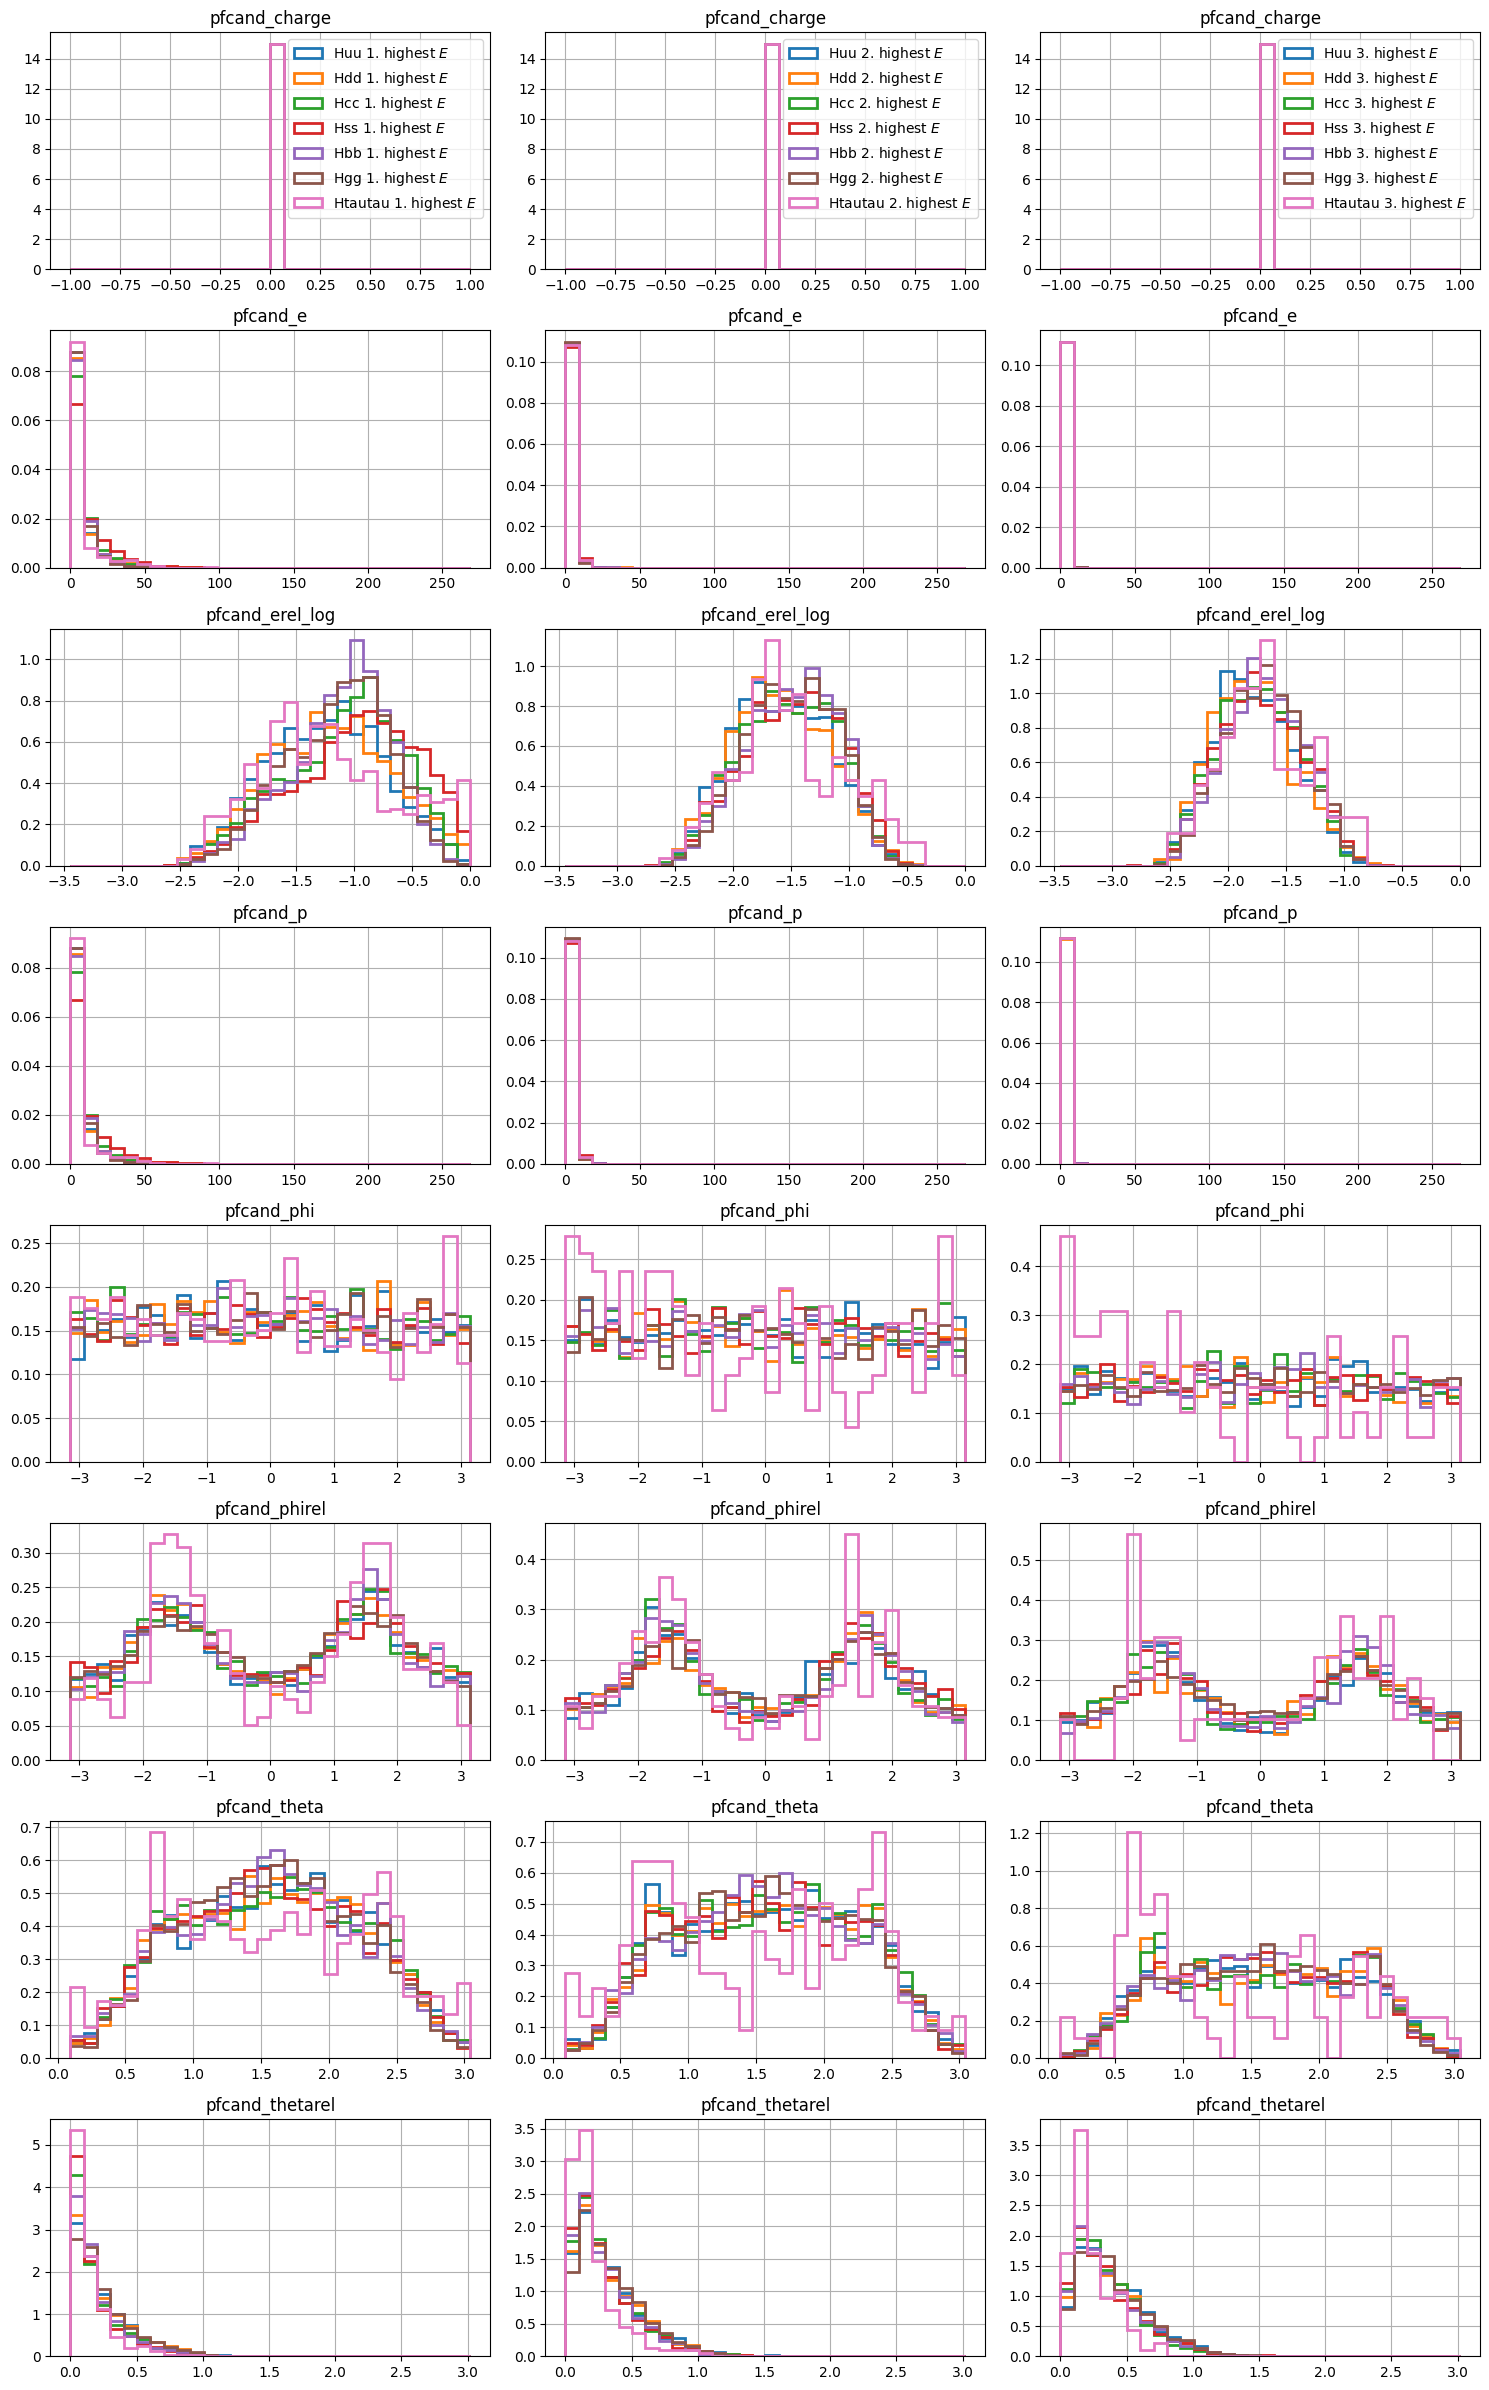

In [24]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, ptype="npart", bins=30, save=save_status, path='./hist-Hxx/jetct_np_properties.pdf')

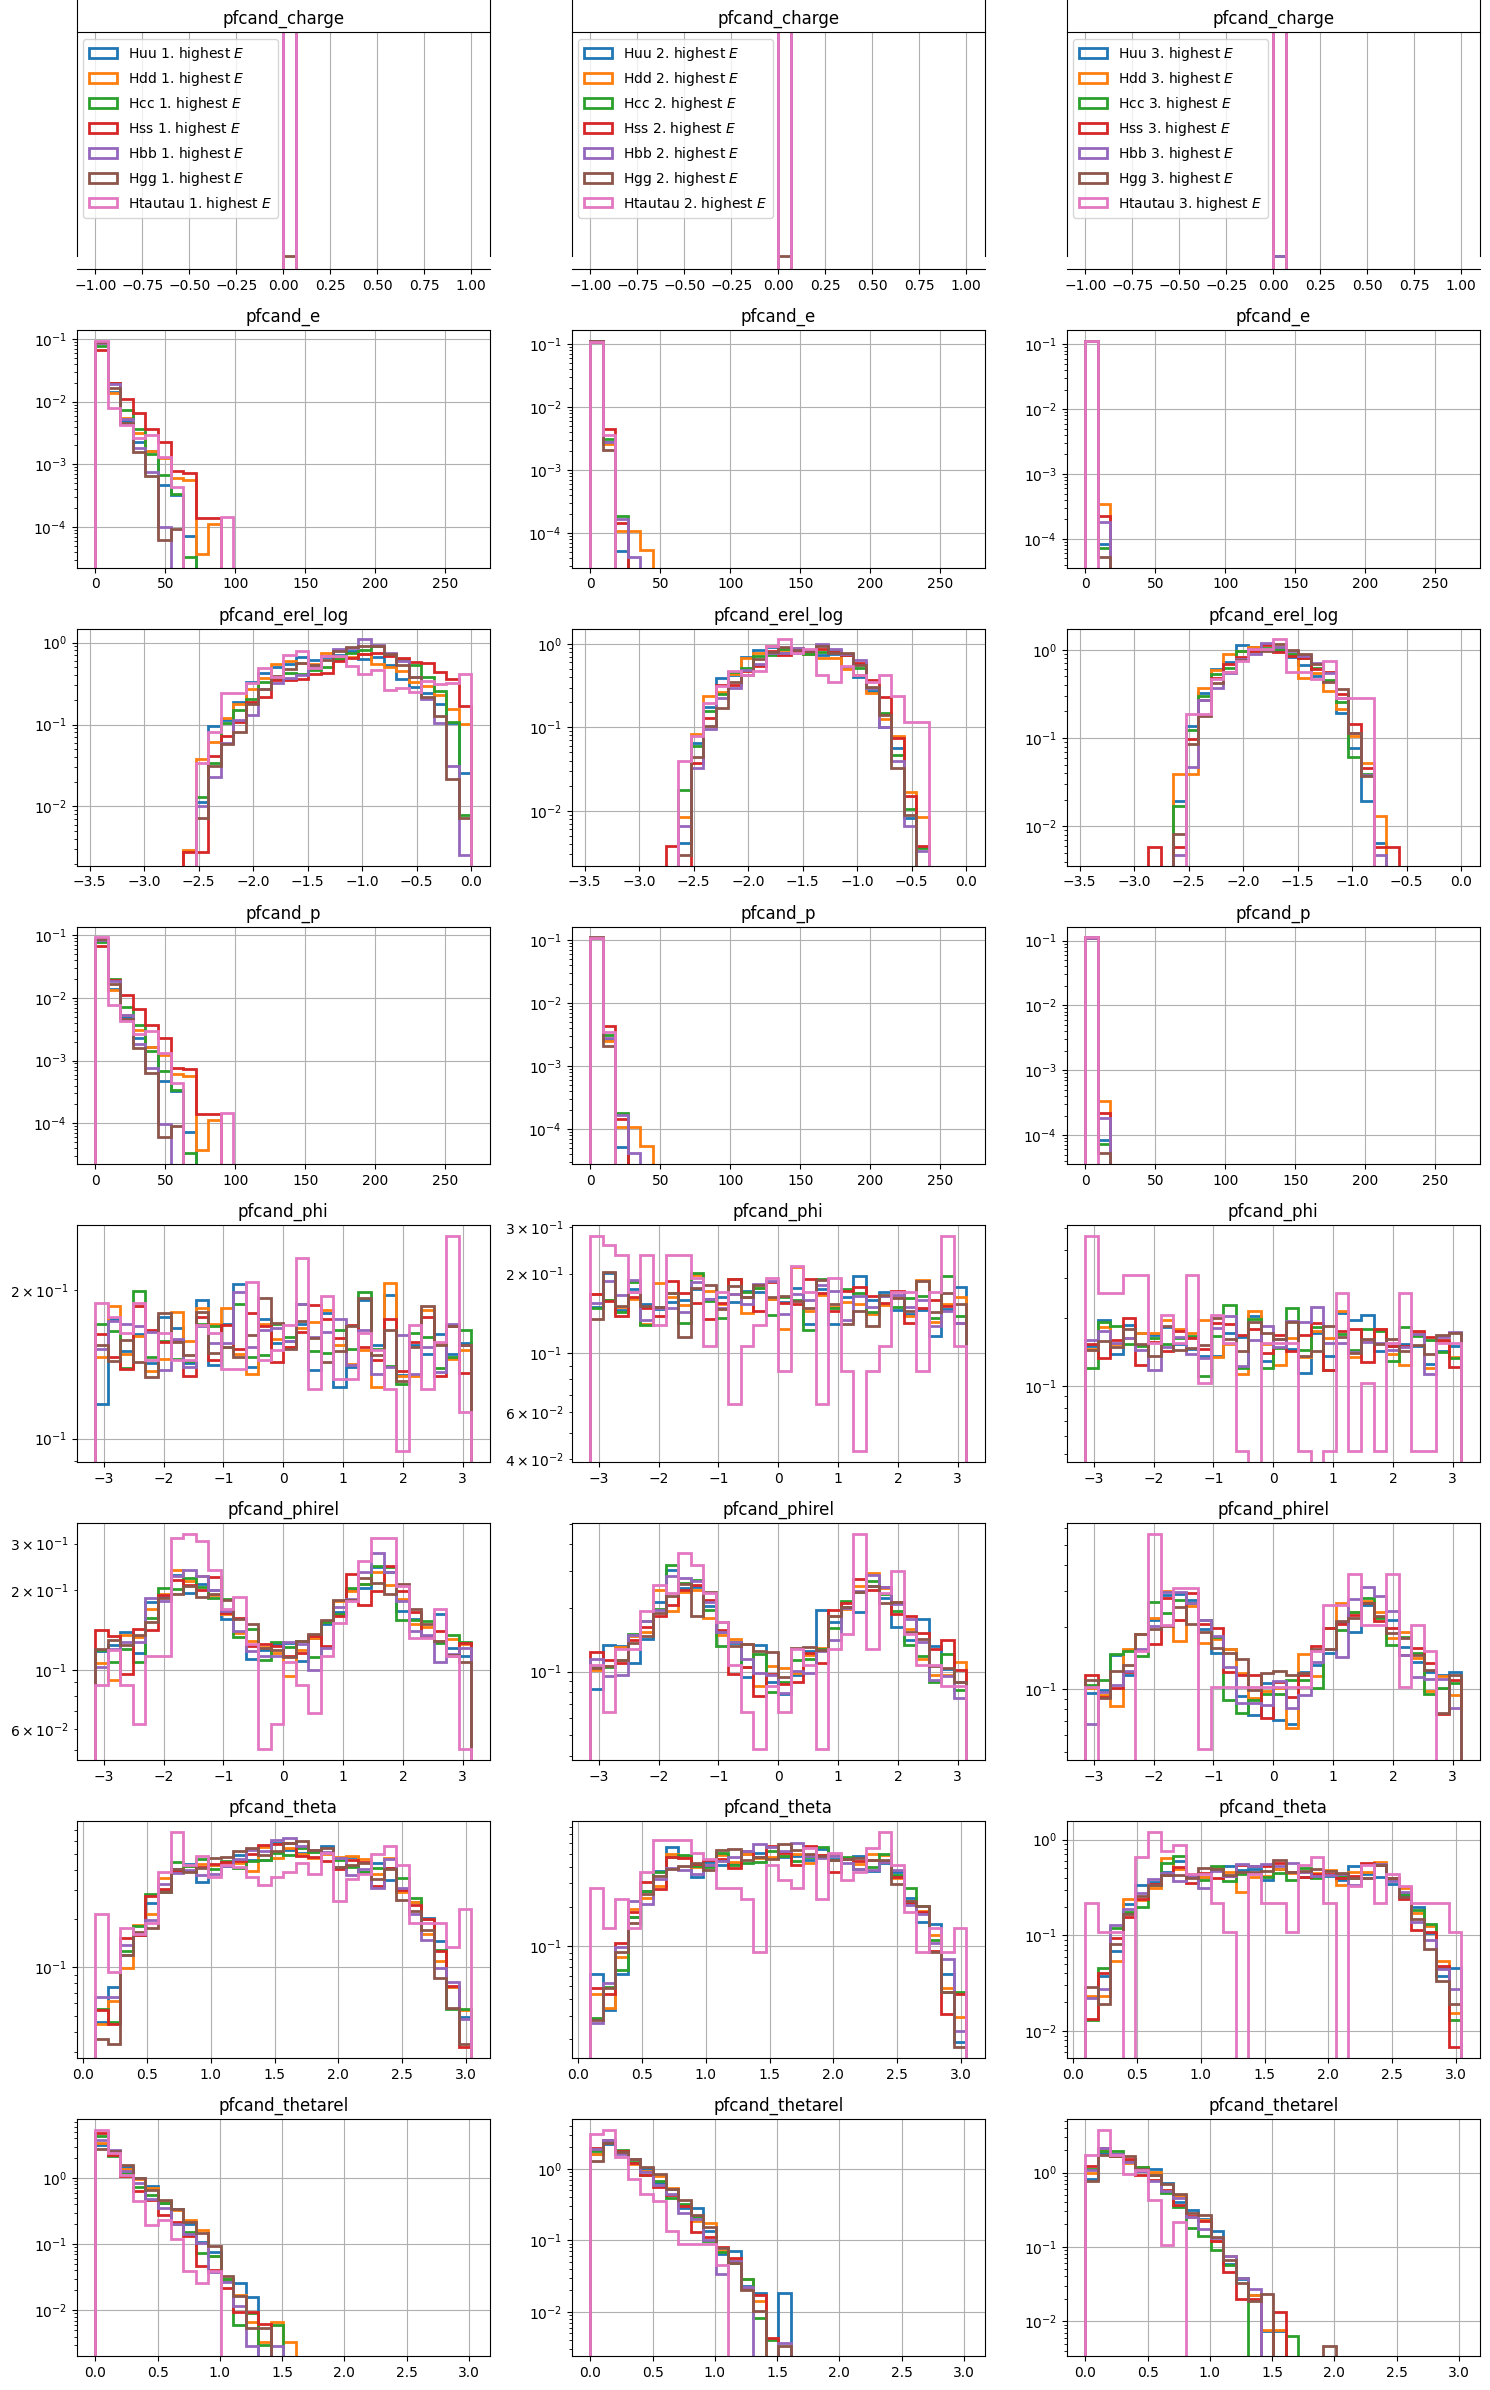

In [25]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, ptype="npart", bins=30, save=save_status, log=True, path='./hist-Hxx/jetct_np_properties_log.pdf')

# Photons 

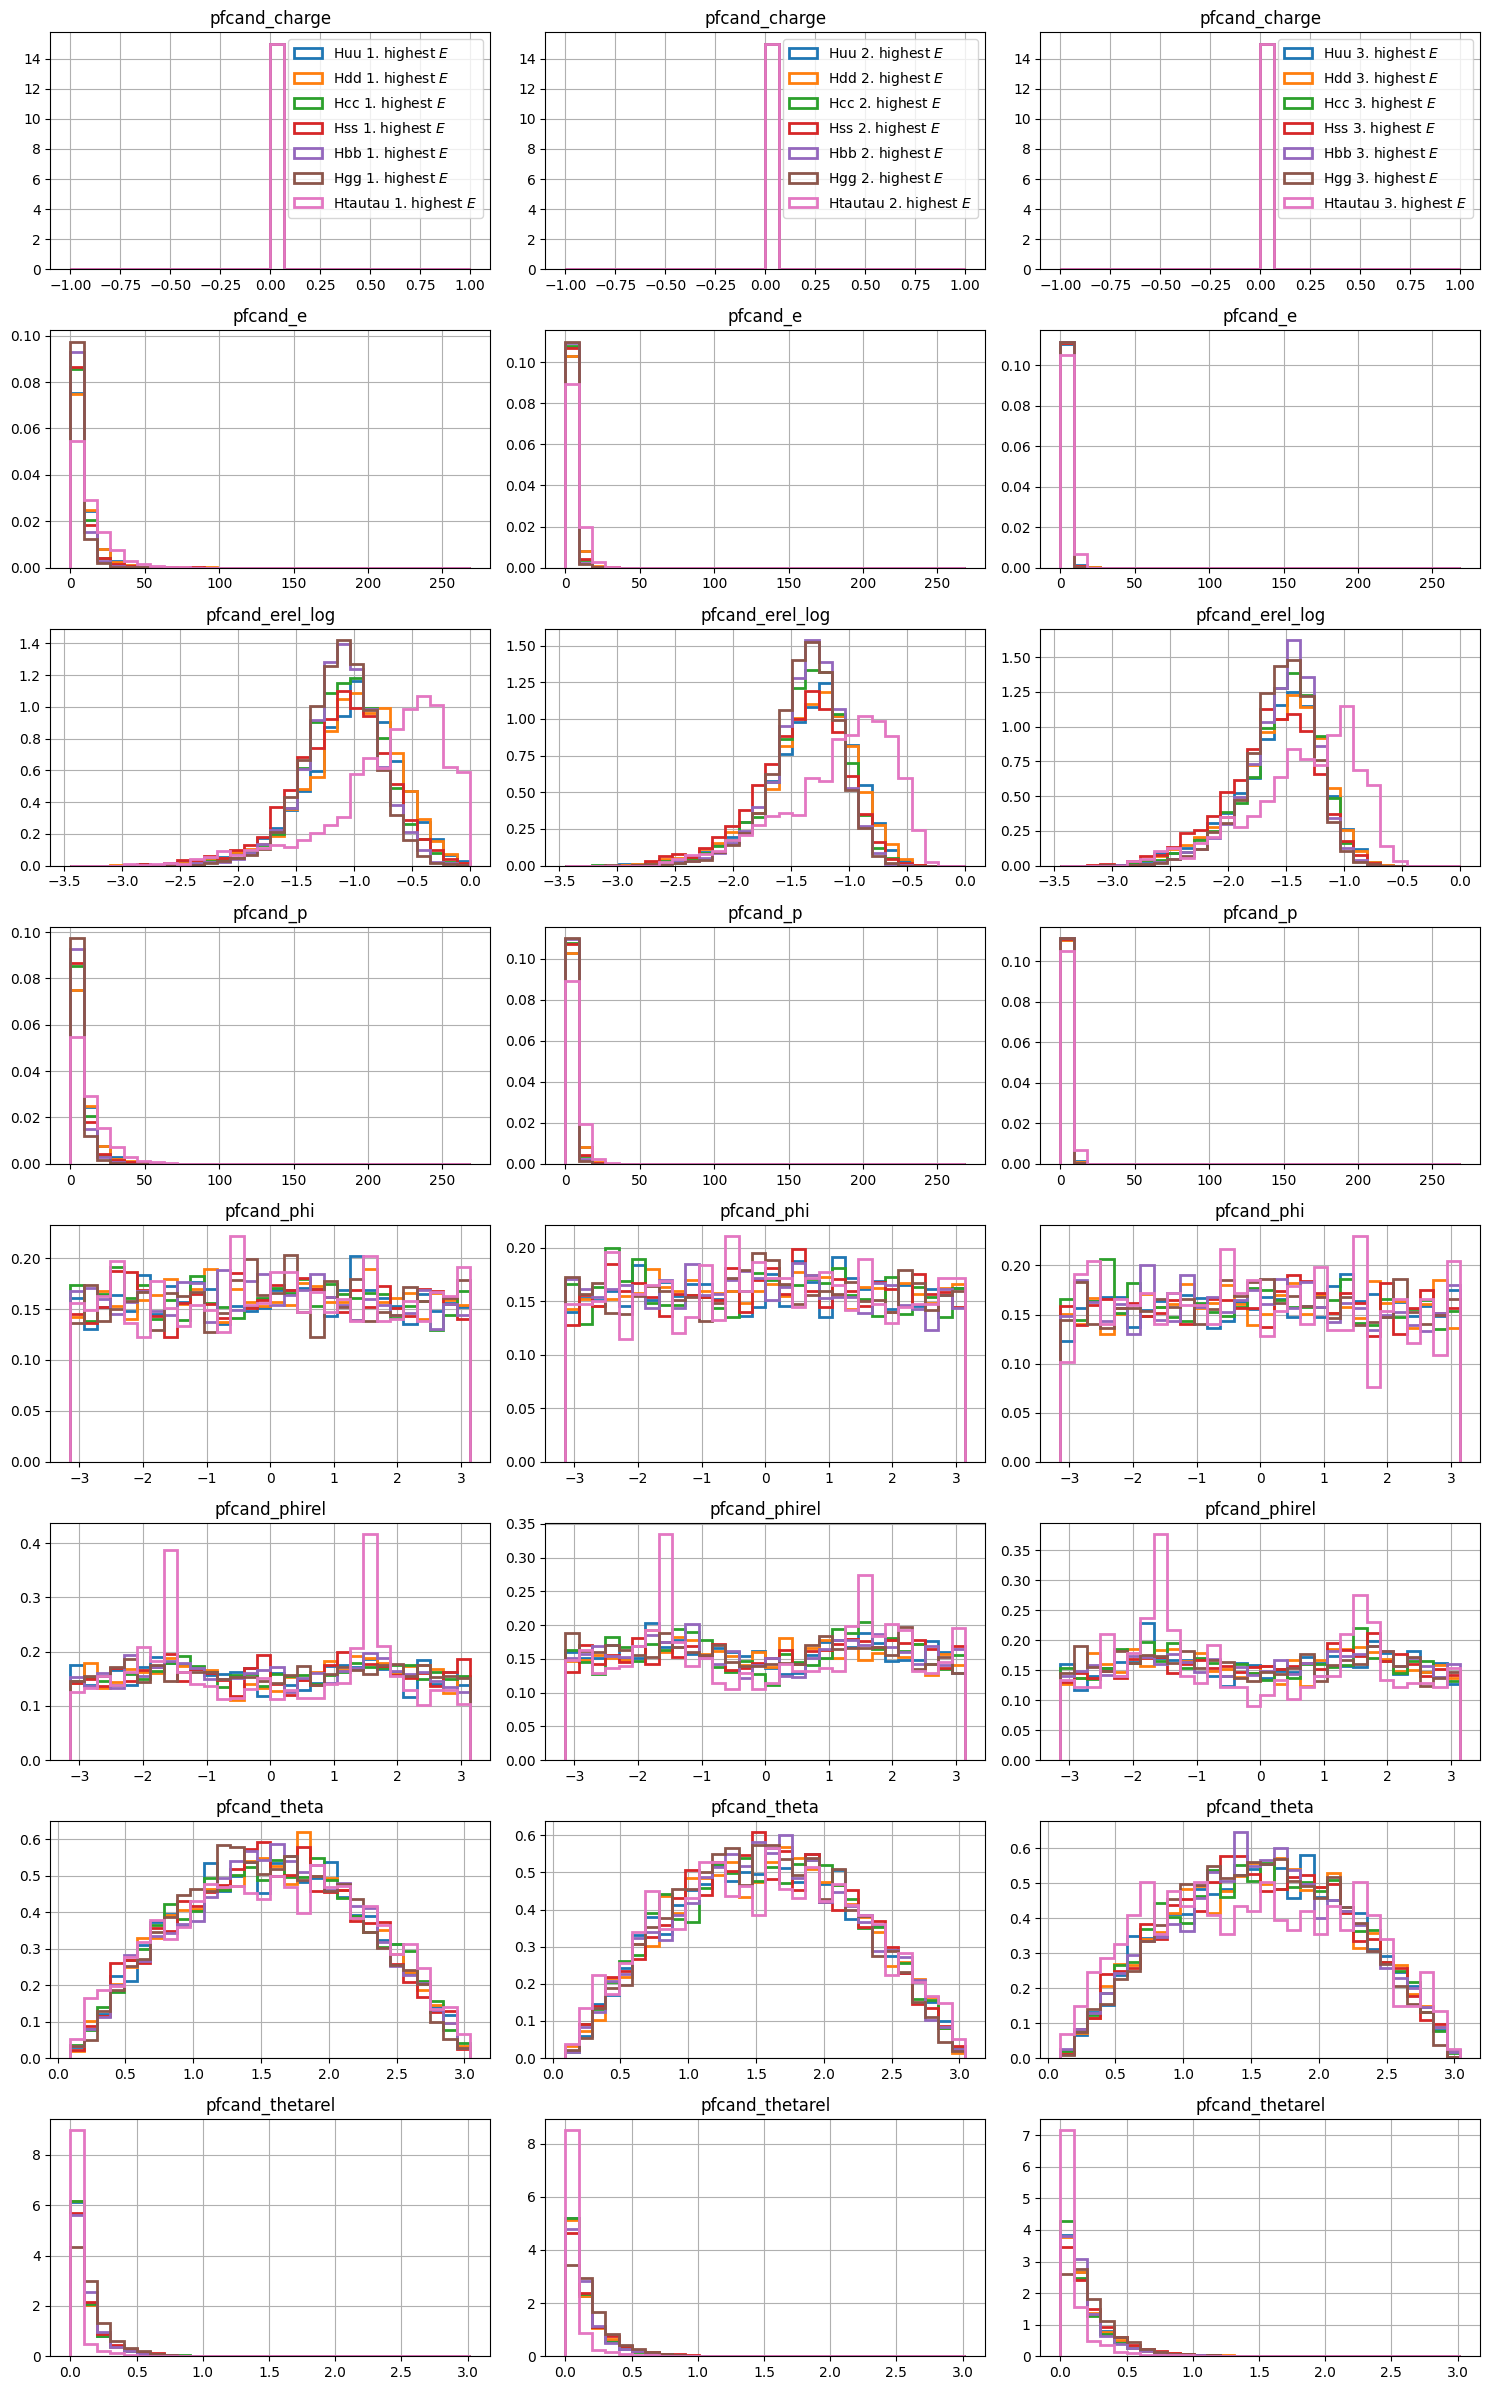

In [26]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, ptype="photon", bins=30, save=save_status, path='./hist-Hxx/jetct_photon_properties.pdf')

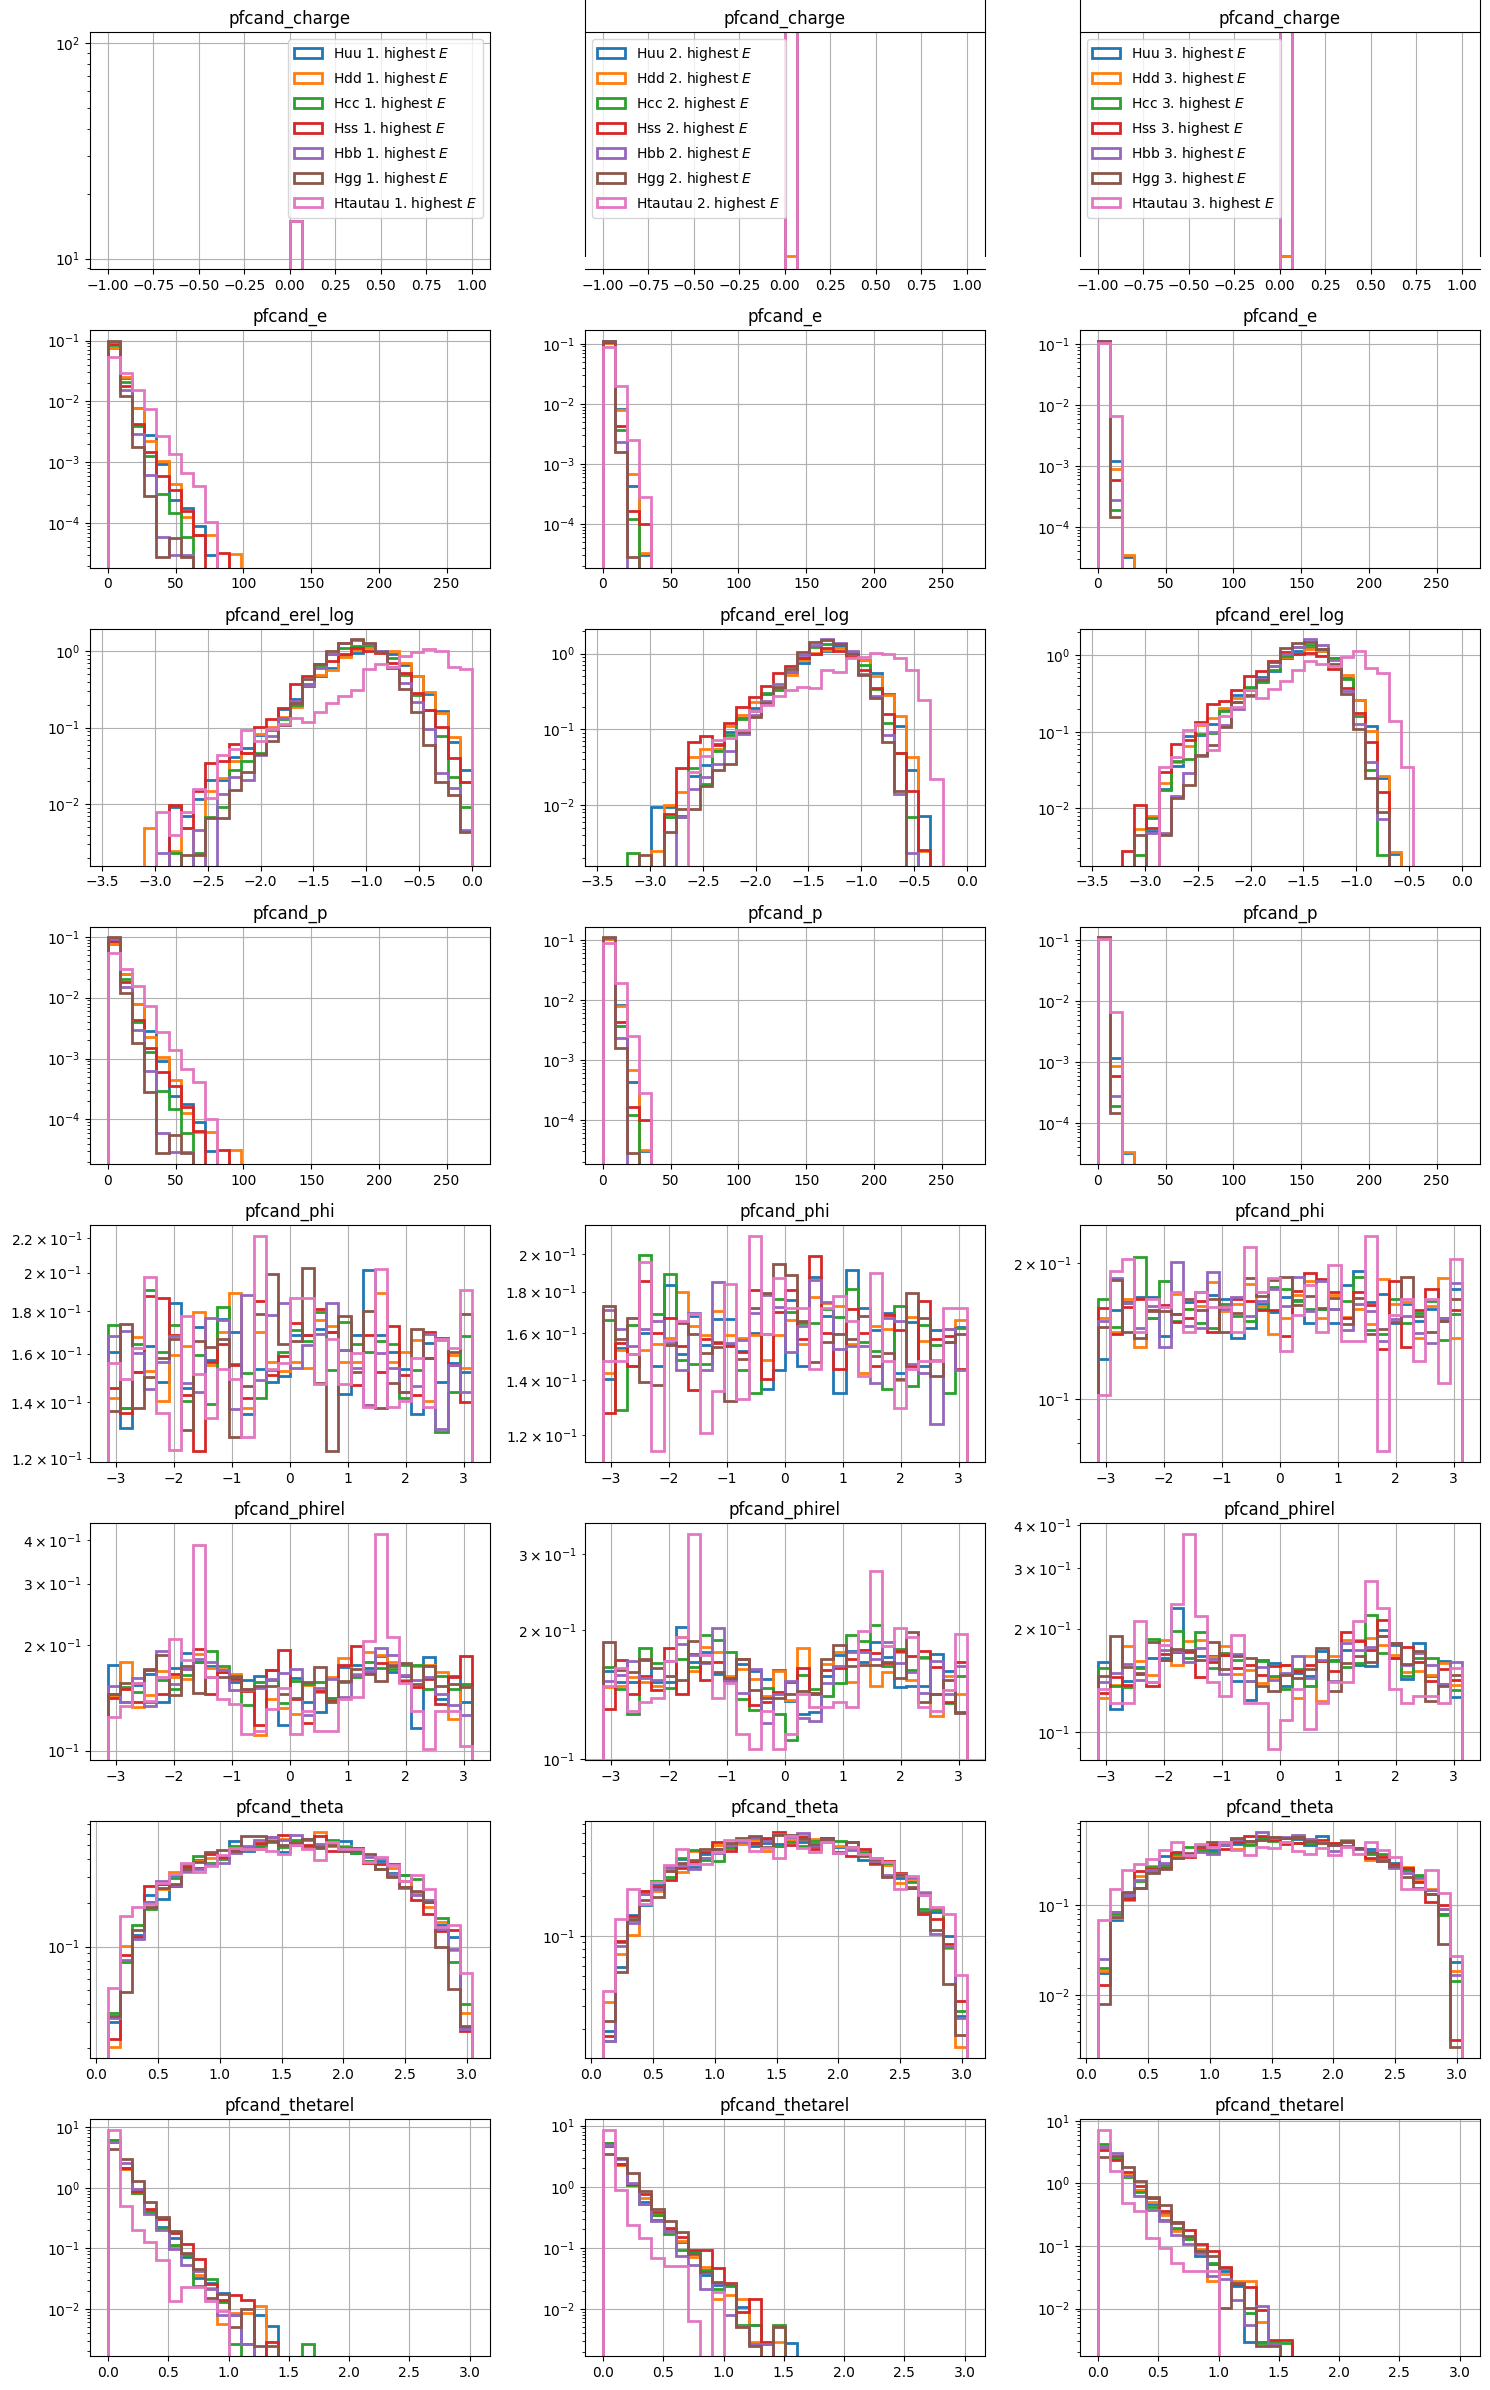

In [27]:
keys= [ 'pfcand_charge',
 'pfcand_e',
 'pfcand_erel_log',
 'pfcand_p',
 'pfcand_phi',
 'pfcand_phirel',
 'pfcand_theta',
 'pfcand_thetarel']

plot_key_highest_e_cpart(keys, ptype="photon", bins=30, save=save_status, log=True, path='./hist-Hxx/jetct_photon_properties_log.pdf')